In [1]:
import os
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np
import random

import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from torchvision.transforms import Compose, ToTensor, Normalize, RandomHorizontalFlip, Resize
from torchvision.transforms import functional as TF

import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision.models as models
from torch.nn.functional import interpolate

from tqdm import tqdm

from sklearn.metrics import jaccard_score

Image count per folder: {'train': 78, 'train_labels': 78, 'val': 15, 'val_labels': 15, 'test': 15, 'test_labels': 15}


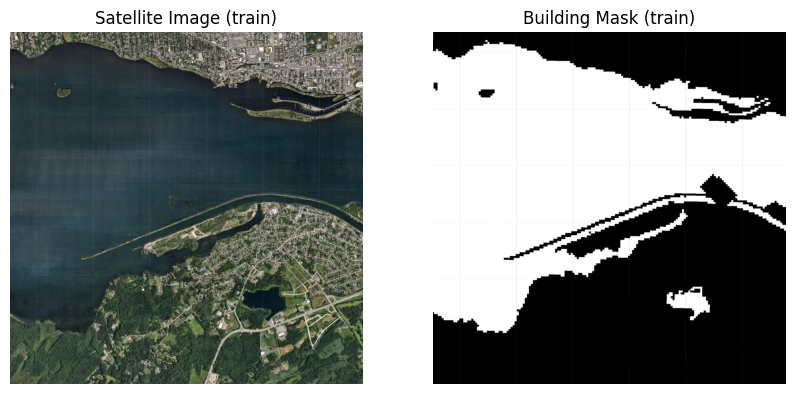

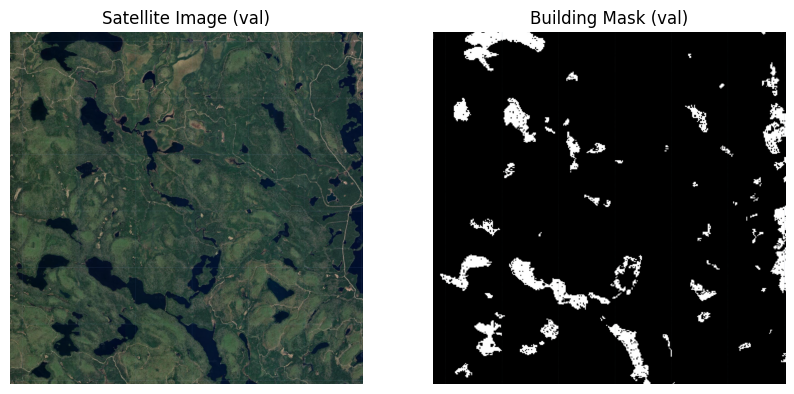

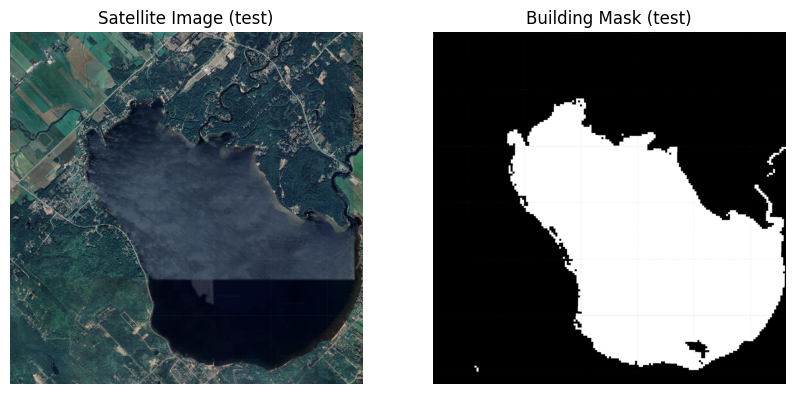

In [2]:
def explore_images(base_path):
    # Define the categories of the folders containing the images and their labels
    categories = ['train', 'train_labels', 'val', 'val_labels', 'test', 'test_labels']
    image_counts = {}
    
    # Iterate over each category to count the image files
    for category in categories:
        # Build the full path to the category folder
        path = os.path.join(base_path, category)
        # Count and store the number of files in each category
        image_counts[category] = len([name for name in os.listdir(path) if os.path.isfile(os.path.join(path, name))])
    
    # Print a summary of the image count for each folder
    print("Image count per folder:", image_counts)
    
    # Categories containing images for display
    sample_images = ['train', 'val', 'test']
    for category in sample_images:
        # Get the list of image files and labels
        images_list = os.listdir(os.path.join(base_path, category))
        labels_list = os.listdir(os.path.join(base_path, f"{category}_labels"))
        
        # Check if the image and label lists are not empty
        if images_list and labels_list:
            # Select the first image and label from the lists for display
            image_path = os.path.join(base_path, category, images_list[0])
            label_path = os.path.join(base_path, f"{category}_labels", labels_list[0])
            
            # Open the image and label with Pillow
            image = Image.open(image_path)
            label = Image.open(label_path)
            
            # Set up the display environment with Matplotlib
            fig, ax = plt.subplots(1, 2, figsize=(10, 5))
            ax[0].imshow(image)
            ax[0].set_title(f'Satellite Image ({category})')
            ax[0].axis('off')
            
            ax[1].imshow(label, cmap='gray')
            ax[1].set_title(f'Building Mask ({category})')
            ax[1].axis('off')
            
            # Display the images and labels
            plt.show()

# Get the current directory and use it to call the function
current_directory = os.getcwd()
explore_images(os.path.join(current_directory, 'BDS/png'))

In [3]:
class SatelliteBuildingDataset(Dataset):
    def __init__(self, image_dir, mask_dir, transform_image=None, transform_mask=None):
        """
        Initializes the SatelliteBuildingDataset class with specific directories for images and masks,
        and with optional transformations that can be applied to both images and masks.

        Args:
            image_dir (string): Directory containing all images.
            mask_dir (string): Directory containing all masks.
            transform_image (callable, optional): Optional transformation function to apply to images.
            transform_mask (callable, optional): Optional transformation function to apply to masks.
        """
        # Assign to instance variables the values of the parameters
        self.image_dir = image_dir
        self.mask_dir = mask_dir
        self.transform_image = transform_image
        self.transform_mask = transform_mask
        # List all files in the image directory. It is assumed that each image has its corresponding mask.
        self.images = os.listdir(image_dir)

    def __len__(self):
        # Returns the total number of images in the dataset
        return len(self.images)

    def __getitem__(self, idx):
        # Build the full paths for the image and mask using the provided index
        img_name = os.path.join(self.image_dir, self.images[idx])
        mask_name = os.path.join(self.mask_dir, self.images[idx])
        
        # Open the image and convert it to RGB color
        image = Image.open(img_name).convert("RGB")
        # Open the mask and convert it to grayscale so that it has a single channel
        mask = Image.open(mask_name).convert("L")  

        # Apply the specified transformations to the image and mask, if provided
        if self.transform_image:
            image = self.transform_image(image)
        if self.transform_mask:
            mask = self.transform_mask(mask)

        # Return the processed image and mask
        return image, mask

In [4]:
def create_dataloaders(base_path, resize, batch_size=4):
    """
    Creates and returns dataloaders for training and validation datasets.
    
    Args:
        base_path (str): Base path where the data folders are located.
        resize (tuple): Dimensions to which all images and masks will be resized.
        batch_size (int, optional): Number of samples per batch. The default value is 4.
    """
    
    # Define transformations to apply to the images:
    # - Resize the images to the specified size.
    # - Convert the images to PyTorch tensors.
    # - Normalize the images using specified means and standard deviations.
    transform_image = Compose([
        Resize(resize),
        ToTensor(),
        Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])
    
    # Define transformations for the masks, which include resizing and conversion to tensor.
    # Masks generally do not require normalization.
    transform_mask = Compose([
        Resize(resize),
        ToTensor()
    ])

    # Build full paths to the training and validation image and mask directories
    train_dir = os.path.join(base_path, 'train')
    train_mask_dir = os.path.join(base_path, 'train_labels')
    val_dir = os.path.join(base_path, 'val')
    val_mask_dir = os.path.join(base_path, 'val_labels')
    
    # Create the training and validation datasets using the SatelliteBuildingDataset class
    train_dataset = SatelliteBuildingDataset(train_dir, train_mask_dir, transform_image, transform_mask)
    val_dataset = SatelliteBuildingDataset(val_dir, val_mask_dir, transform_image, transform_mask)

    # Create dataloaders for the training and validation datasets.
    # The training dataloader shuffles the data (shuffle=True) to improve training.
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

    # Return the training and validation dataloaders
    return train_loader, val_loader

In [5]:
# Assuming you are running this from the main directory of your project
base_path = os.getcwd()
base_path = os.path.join(base_path, 'BDS/png')

In [6]:
# We create the model, as well as the loss function. 
# The model is of the U-Net type, with 4 encoder downsampling blocks and 4 decoder upsampling blocks.

class DoubleConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        """
        Double convolution block that applies two convolution layers with a batch normalization 
        and ReLU activation between them.

        Args:
            in_channels (int): Number of input channels.
            out_channels (int): Number of output channels.
        """
        super(DoubleConv, self).__init__()
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
        )

    def forward(self, x):
        return self.double_conv(x)
    
    
class DownBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        """
        DownBlock in U-Net that includes a DoubleConv followed by max pooling 
        to reduce spatial dimension.

        Args:
            in_channels (int): Number of input channels.
            out_channels (int): Number of output channels after DoubleConv.
        """
        super(DownBlock, self).__init__()
        self.double_conv = DoubleConv(in_channels, out_channels)
        self.down_sample = nn.MaxPool2d(2)

    def forward(self, x):
        skip_out = self.double_conv(x)
        down_out = self.down_sample(skip_out)
        return (down_out, skip_out)

    
class UpBlock(nn.Module):
    def __init__(self, in_channels, out_channels, up_sample_mode):
        """
        UpBlock in U-Net that performs upsampling and combines features
        from earlier layers through concatenation operation.

        Args:
            in_channels (int): Total number of input channels (sum of output channels from previous block and skip connection).
            out_channels (int): Number of output channels.
            up_sample_mode (str): Upsampling mode, 'conv_transpose' for ConvTranspose2d or 'bilinear' for bilinear interpolation.
        """
        super(UpBlock, self).__init__()
        if up_sample_mode == 'conv_transpose':
            self.up_sample = nn.ConvTranspose2d(in_channels - out_channels, in_channels - out_channels, kernel_size=2, stride=2)        
        elif up_sample_mode == 'bilinear':
            self.up_sample = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
        else:
            raise ValueError("Unsupported `up_sample_mode` (can take one of `conv_transpose` or `bilinear`)")
        self.double_conv = DoubleConv(in_channels, out_channels)

    def forward(self, down_input, skip_input):
        x = self.up_sample(down_input)
        x = torch.cat([x, skip_input], dim=1)
        return self.double_conv(x)

    
class UNet(nn.Module):
    def __init__(self, out_classes=1, up_sample_mode='conv_transpose'):
        """
        U-Net architecture for segmentation that includes descending and ascending paths with a bottleneck.

        Args:
            out_classes (int): Number of output classes (usually 1 for binary segmentation masks).
            up_sample_mode (str): Upsampling mode used in the ascent blocks.
        """
        super(UNet, self).__init__()
        self.up_sample_mode = up_sample_mode
        self.down_conv1 = DownBlock(3, 64)
        self.down_conv2 = DownBlock(64, 128)
        self.down_conv3 = DownBlock(128, 256)
        self.down_conv4 = DownBlock(256, 512)
        self.double_conv = DoubleConv(512, 1024)
        self.up_conv4 = UpBlock(1024 + 512, 512, self.up_sample_mode)
        self.up_conv3 = UpBlock(512 + 256, 256, self.up_sample_mode)
        self.up_conv2 = UpBlock(256 + 128, 128, self.up_sample_mode)
        self.up_conv1 = UpBlock(128 + 64, 64, self.up_sample_mode)
        self.conv_last = nn.Conv2d(64, out_classes, kernel_size=1)

    def forward(self, x):
        x, skip1_out = self.down_conv1(x)
        x, skip2_out = self.down_conv2(x)
        x, skip3_out = self.down_conv3(x)
        x, skip4_out = self.down_conv4(x)
        x = self.double_conv(x)
        x = self.up_conv4(x, skip4_out)
        x = self.up_conv3(x, skip3_out)
        x = self.up_conv2(x, skip2_out)
        x = self.up_conv1(x, skip1_out)
        x = self.conv_last(x)
        return x


class DiceLoss(nn.Module):
    def __init__(self, smooth=1.):
        """
        Implementation of the Dice Loss, useful for comparing the similarity between two samples.

        Args:
            smooth (float): Value to prevent division by zero and smooth the result.
        """
        super(DiceLoss, self).__init__()
        self.smooth = smooth

    def forward(self, inputs, targets):
        inputs = torch.sigmoid(inputs)  # Convert logits to probabilities
        inputs = inputs.view(-1)
        targets = targets.view(-1)

        intersection = (inputs * targets).sum()                            
        dice = (2. * intersection + self.smooth) / (inputs.sum() + targets.sum() + self.smooth)  
        
        return 1 - dice

In [7]:
# Load the model
model = UNet()
# Check if CUDA is available and move the model to the appropriate device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Loss function and optimizer
criterion = DiceLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)

In [8]:
# We add the IoU as a metric to see how the model progresses and performs. 
# The training metric is Dice, but it's good to have more than one metric if possible.

def calculate_iou(outputs, masks):
    """
    Calcula el promedio de la métrica Intersección sobre Unión (IoU) entre las salidas del modelo y las máscaras verdaderas.

    Args:
        outputs: Salidas del modelo (logits).
        masks: Máscaras verdaderas (ground truth).

    Returns:
        Un valor flotante que representa el IoU promedio.
    """
    outputs = torch.sigmoid(outputs) > 0.5  # Convertir logits a predicciones binarias
    outputs = outputs.cpu().numpy().astype(np.uint8)  # Convertir a NumPy para cálculo
    masks = masks.cpu().numpy().astype(np.uint8)
    
    # Calcular IoU para cada par de salida y máscara
    ious = [jaccard_score(m.flatten(), o.flatten()) for m, o in zip(masks, outputs)]
    return np.mean(ious)

def weight_reset(m):
    """
    Reinicia los pesos de las capas convolucionales y lineales a sus valores iniciales.

    Args:
        m: Módulo de PyTorch (capa).
    """
    if isinstance(m, nn.Conv2d) or isinstance(m, nn.Linear):
        m.reset_parameters()

Training model with image size: (224, 224)


Epoch 1/500 Training:   0%|          | 0/20 [00:00<?, ?it/s]d:\Development\Anaconda3\envs\coen6331\lib\site-packages\torch\autograd\graph.py:744: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\native\cudnn\Conv_v8.cpp:919.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass
Epoch 1/500 Validation: 100%|██████████| 4/4 [00:02<00:00,  1.70it/s]


Epoch 1/500, Train Loss: 0.6996, Val Loss: 0.8180, Average IoU: 0.0513
Model saved to saved_models\model_BDS224x224.pth


Epoch 2/500 Validation: 100%|██████████| 4/4 [00:02<00:00,  1.88it/s]


Epoch 2/500, Train Loss: 0.5433, Val Loss: 0.7698, Average IoU: 0.0877
Model saved to saved_models\model_BDS224x224.pth


Epoch 3/500 Validation: 100%|██████████| 4/4 [00:02<00:00,  1.79it/s]


Epoch 3/500, Train Loss: 0.5349, Val Loss: 0.7361, Average IoU: 0.1007
Model saved to saved_models\model_BDS224x224.pth


Epoch 4/500 Validation: 100%|██████████| 4/4 [00:02<00:00,  1.79it/s]


Epoch 4/500, Train Loss: 0.5144, Val Loss: 0.6847, Average IoU: 0.2893
Model saved to saved_models\model_BDS224x224.pth


Epoch 5/500 Validation: 100%|██████████| 4/4 [00:02<00:00,  1.82it/s]


Epoch 5/500, Train Loss: 0.5484, Val Loss: 0.7066, Average IoU: 0.1269


Epoch 6/500 Validation: 100%|██████████| 4/4 [00:02<00:00,  1.76it/s]


Epoch 6/500, Train Loss: 0.5058, Val Loss: 0.6917, Average IoU: 0.1413


Epoch 7/500 Validation: 100%|██████████| 4/4 [00:02<00:00,  1.88it/s]


Epoch 7/500, Train Loss: 0.5249, Val Loss: 0.6351, Average IoU: 0.2443
Model saved to saved_models\model_BDS224x224.pth


Epoch 8/500 Validation: 100%|██████████| 4/4 [00:02<00:00,  1.76it/s]


Epoch 8/500, Train Loss: 0.4992, Val Loss: 0.6825, Average IoU: 0.1557


Epoch 9/500 Validation: 100%|██████████| 4/4 [00:02<00:00,  1.80it/s]


Epoch 9/500, Train Loss: 0.4857, Val Loss: 0.6114, Average IoU: 0.2284
Model saved to saved_models\model_BDS224x224.pth


Epoch 10/500 Validation: 100%|██████████| 4/4 [00:02<00:00,  1.83it/s]


Epoch 10/500, Train Loss: 0.4987, Val Loss: 0.7176, Average IoU: 0.1012


Epoch 11/500 Validation: 100%|██████████| 4/4 [00:02<00:00,  1.87it/s]


Epoch 11/500, Train Loss: 0.5225, Val Loss: 0.6803, Average IoU: 0.1299


Epoch 12/500 Validation: 100%|██████████| 4/4 [00:02<00:00,  1.82it/s]


Epoch 12/500, Train Loss: 0.4817, Val Loss: 0.6707, Average IoU: 0.1461


Epoch 13/500 Validation: 100%|██████████| 4/4 [00:02<00:00,  1.74it/s]


Epoch 13/500, Train Loss: 0.4801, Val Loss: 0.6268, Average IoU: 0.1777


Epoch 14/500 Validation: 100%|██████████| 4/4 [00:02<00:00,  1.83it/s]


Epoch 14/500, Train Loss: 0.4703, Val Loss: 0.6089, Average IoU: 0.2325
Model saved to saved_models\model_BDS224x224.pth


Epoch 15/500 Validation: 100%|██████████| 4/4 [00:02<00:00,  1.80it/s]


Epoch 15/500, Train Loss: 0.4492, Val Loss: 0.6090, Average IoU: 0.2638


Epoch 16/500 Validation: 100%|██████████| 4/4 [00:02<00:00,  1.84it/s]


Epoch 16/500, Train Loss: 0.4667, Val Loss: 0.7062, Average IoU: 0.1059


Epoch 17/500 Validation: 100%|██████████| 4/4 [00:02<00:00,  1.85it/s]


Epoch 17/500, Train Loss: 0.4212, Val Loss: 0.6329, Average IoU: 0.2032


Epoch 18/500 Validation: 100%|██████████| 4/4 [00:02<00:00,  1.80it/s]


Epoch 18/500, Train Loss: 0.4073, Val Loss: 0.6157, Average IoU: 0.1728


Epoch 19/500 Validation: 100%|██████████| 4/4 [00:02<00:00,  1.85it/s]


Epoch 19/500, Train Loss: 0.4277, Val Loss: 0.5545, Average IoU: 0.2427
Model saved to saved_models\model_BDS224x224.pth


Epoch 20/500 Validation: 100%|██████████| 4/4 [00:02<00:00,  1.85it/s]


Epoch 20/500, Train Loss: 0.4247, Val Loss: 0.5591, Average IoU: 0.2873


Epoch 21/500 Validation: 100%|██████████| 4/4 [00:02<00:00,  1.80it/s]


Epoch 21/500, Train Loss: 0.5051, Val Loss: 0.6327, Average IoU: 0.1617


Epoch 22/500 Validation: 100%|██████████| 4/4 [00:02<00:00,  1.83it/s]


Epoch 22/500, Train Loss: 0.3880, Val Loss: 0.6185, Average IoU: 0.1821


Epoch 23/500 Validation: 100%|██████████| 4/4 [00:02<00:00,  1.83it/s]


Epoch 23/500, Train Loss: 0.4023, Val Loss: 0.5772, Average IoU: 0.2263


Epoch 24/500 Validation: 100%|██████████| 4/4 [00:02<00:00,  1.92it/s]


Epoch 24/500, Train Loss: 0.4355, Val Loss: 0.5426, Average IoU: 0.2283
Model saved to saved_models\model_BDS224x224.pth


Epoch 25/500 Validation: 100%|██████████| 4/4 [00:02<00:00,  1.81it/s]


Epoch 25/500, Train Loss: 0.4323, Val Loss: 0.5653, Average IoU: 0.2808


Epoch 26/500 Validation: 100%|██████████| 4/4 [00:02<00:00,  1.80it/s]


Epoch 26/500, Train Loss: 0.4005, Val Loss: 0.5995, Average IoU: 0.1534


Epoch 27/500 Validation: 100%|██████████| 4/4 [00:02<00:00,  1.92it/s]


Epoch 27/500, Train Loss: 0.3510, Val Loss: 0.5397, Average IoU: 0.3107
Model saved to saved_models\model_BDS224x224.pth


Epoch 28/500 Validation: 100%|██████████| 4/4 [00:02<00:00,  1.82it/s]


Epoch 28/500, Train Loss: 0.4003, Val Loss: 0.5106, Average IoU: 0.2226
Model saved to saved_models\model_BDS224x224.pth


Epoch 29/500 Validation: 100%|██████████| 4/4 [00:02<00:00,  1.87it/s]


Epoch 29/500, Train Loss: 0.3917, Val Loss: 0.5219, Average IoU: 0.2234


Epoch 30/500 Validation: 100%|██████████| 4/4 [00:02<00:00,  1.91it/s]


Epoch 30/500, Train Loss: 0.3564, Val Loss: 0.4817, Average IoU: 0.2998
Model saved to saved_models\model_BDS224x224.pth


Epoch 31/500 Validation: 100%|██████████| 4/4 [00:02<00:00,  1.87it/s]


Epoch 31/500, Train Loss: 0.3606, Val Loss: 0.4824, Average IoU: 0.3325


Epoch 32/500 Validation: 100%|██████████| 4/4 [00:02<00:00,  1.86it/s]


Epoch 32/500, Train Loss: 0.3659, Val Loss: 0.5771, Average IoU: 0.3347


Epoch 33/500 Validation: 100%|██████████| 4/4 [00:02<00:00,  1.90it/s]


Epoch 33/500, Train Loss: 0.3164, Val Loss: 0.5002, Average IoU: 0.2231


Epoch 34/500 Validation: 100%|██████████| 4/4 [00:02<00:00,  1.88it/s]


Epoch 34/500, Train Loss: 0.3655, Val Loss: 0.5203, Average IoU: 0.1983


Epoch 35/500 Validation: 100%|██████████| 4/4 [00:02<00:00,  1.87it/s]


Epoch 35/500, Train Loss: 0.3880, Val Loss: 0.5290, Average IoU: 0.1800


Epoch 36/500 Validation: 100%|██████████| 4/4 [00:02<00:00,  1.80it/s]


Epoch 36/500, Train Loss: 0.3984, Val Loss: 0.4938, Average IoU: 0.2534


Epoch 37/500 Validation: 100%|██████████| 4/4 [00:02<00:00,  1.89it/s]


Epoch 37/500, Train Loss: 0.3846, Val Loss: 0.5322, Average IoU: 0.2924


Epoch 38/500 Validation: 100%|██████████| 4/4 [00:02<00:00,  1.88it/s]


Epoch 38/500, Train Loss: 0.3878, Val Loss: 0.5260, Average IoU: 0.2776


Epoch 39/500 Validation: 100%|██████████| 4/4 [00:02<00:00,  1.85it/s]


Epoch 39/500, Train Loss: 0.3884, Val Loss: 0.5521, Average IoU: 0.1582


Epoch 40/500 Validation: 100%|██████████| 4/4 [00:02<00:00,  1.84it/s]


Epoch 40/500, Train Loss: 0.3763, Val Loss: 0.4683, Average IoU: 0.3309
Model saved to saved_models\model_BDS224x224.pth


Epoch 41/500 Validation: 100%|██████████| 4/4 [00:02<00:00,  1.79it/s]


Epoch 41/500, Train Loss: 0.3046, Val Loss: 0.4499, Average IoU: 0.2993
Model saved to saved_models\model_BDS224x224.pth


Epoch 42/500 Validation: 100%|██████████| 4/4 [00:02<00:00,  1.81it/s]


Epoch 42/500, Train Loss: 0.3271, Val Loss: 0.4600, Average IoU: 0.2768


Epoch 43/500 Validation: 100%|██████████| 4/4 [00:02<00:00,  1.77it/s]


Epoch 43/500, Train Loss: 0.3869, Val Loss: 0.4298, Average IoU: 0.3300
Model saved to saved_models\model_BDS224x224.pth


Epoch 44/500 Validation: 100%|██████████| 4/4 [00:02<00:00,  1.85it/s]


Epoch 44/500, Train Loss: 0.2853, Val Loss: 0.4336, Average IoU: 0.3055


Epoch 45/500 Validation: 100%|██████████| 4/4 [00:02<00:00,  1.85it/s]


Epoch 45/500, Train Loss: 0.2596, Val Loss: 0.4467, Average IoU: 0.3155


Epoch 46/500 Validation: 100%|██████████| 4/4 [00:02<00:00,  1.87it/s]


Epoch 46/500, Train Loss: 0.3631, Val Loss: 0.5307, Average IoU: 0.2147


Epoch 47/500 Validation: 100%|██████████| 4/4 [00:02<00:00,  1.82it/s]


Epoch 47/500, Train Loss: 0.3040, Val Loss: 0.4474, Average IoU: 0.3213


Epoch 48/500 Validation: 100%|██████████| 4/4 [00:02<00:00,  1.86it/s]


Epoch 48/500, Train Loss: 0.2719, Val Loss: 0.4791, Average IoU: 0.3084


Epoch 49/500 Validation: 100%|██████████| 4/4 [00:02<00:00,  1.82it/s]


Epoch 49/500, Train Loss: 0.2959, Val Loss: 0.4804, Average IoU: 0.1972


Epoch 50/500 Validation: 100%|██████████| 4/4 [00:02<00:00,  1.87it/s]


Epoch 50/500, Train Loss: 0.3044, Val Loss: 0.4309, Average IoU: 0.3093


Epoch 51/500 Validation: 100%|██████████| 4/4 [00:02<00:00,  1.90it/s]


Epoch 51/500, Train Loss: 0.3169, Val Loss: 0.4134, Average IoU: 0.3157
Model saved to saved_models\model_BDS224x224.pth


Epoch 52/500 Validation: 100%|██████████| 4/4 [00:02<00:00,  1.86it/s]


Epoch 52/500, Train Loss: 0.3248, Val Loss: 0.5015, Average IoU: 0.3288


Epoch 53/500 Validation: 100%|██████████| 4/4 [00:02<00:00,  1.87it/s]


Epoch 53/500, Train Loss: 0.2843, Val Loss: 0.4932, Average IoU: 0.2357


Epoch 54/500 Validation: 100%|██████████| 4/4 [00:02<00:00,  1.83it/s]


Epoch 54/500, Train Loss: 0.2946, Val Loss: 0.5180, Average IoU: 0.2497


Epoch 55/500 Validation: 100%|██████████| 4/4 [00:02<00:00,  1.85it/s]


Epoch 55/500, Train Loss: 0.2471, Val Loss: 0.4089, Average IoU: 0.3348
Model saved to saved_models\model_BDS224x224.pth


Epoch 56/500 Validation: 100%|██████████| 4/4 [00:02<00:00,  1.86it/s]


Epoch 56/500, Train Loss: 0.2189, Val Loss: 0.4293, Average IoU: 0.3213


Epoch 57/500 Validation: 100%|██████████| 4/4 [00:02<00:00,  1.90it/s]


Epoch 57/500, Train Loss: 0.2738, Val Loss: 0.4098, Average IoU: 0.3379


Epoch 58/500 Validation: 100%|██████████| 4/4 [00:02<00:00,  1.74it/s]


Epoch 58/500, Train Loss: 0.2328, Val Loss: 0.5072, Average IoU: 0.2240


Epoch 59/500 Validation: 100%|██████████| 4/4 [00:02<00:00,  1.79it/s]


Epoch 59/500, Train Loss: 0.2535, Val Loss: 0.4775, Average IoU: 0.3027


Epoch 60/500 Validation: 100%|██████████| 4/4 [00:02<00:00,  1.81it/s]


Epoch 60/500, Train Loss: 0.2319, Val Loss: 0.4300, Average IoU: 0.2667


Epoch 61/500 Validation: 100%|██████████| 4/4 [00:02<00:00,  1.88it/s]


Epoch 61/500, Train Loss: 0.2520, Val Loss: 0.3780, Average IoU: 0.3263
Model saved to saved_models\model_BDS224x224.pth


Epoch 62/500 Validation: 100%|██████████| 4/4 [00:02<00:00,  1.87it/s]


Epoch 62/500, Train Loss: 0.2614, Val Loss: 0.4837, Average IoU: 0.2204


Epoch 63/500 Validation: 100%|██████████| 4/4 [00:02<00:00,  1.85it/s]


Epoch 63/500, Train Loss: 0.2126, Val Loss: 0.3947, Average IoU: 0.3434


Epoch 64/500 Validation: 100%|██████████| 4/4 [00:02<00:00,  1.89it/s]


Epoch 64/500, Train Loss: 0.2342, Val Loss: 0.4250, Average IoU: 0.3620


Epoch 65/500 Validation: 100%|██████████| 4/4 [00:02<00:00,  1.86it/s]


Epoch 65/500, Train Loss: 0.2115, Val Loss: 0.3980, Average IoU: 0.2920


Epoch 66/500 Validation: 100%|██████████| 4/4 [00:02<00:00,  1.85it/s]


Epoch 66/500, Train Loss: 0.2492, Val Loss: 0.4656, Average IoU: 0.3252


Epoch 67/500 Validation: 100%|██████████| 4/4 [00:02<00:00,  1.88it/s]


Epoch 67/500, Train Loss: 0.2334, Val Loss: 0.4031, Average IoU: 0.2616


Epoch 68/500 Validation: 100%|██████████| 4/4 [00:02<00:00,  1.81it/s]


Epoch 68/500, Train Loss: 0.2772, Val Loss: 0.3763, Average IoU: 0.2925
Model saved to saved_models\model_BDS224x224.pth


Epoch 69/500 Validation: 100%|██████████| 4/4 [00:02<00:00,  1.89it/s]


Epoch 69/500, Train Loss: 0.1940, Val Loss: 0.3763, Average IoU: 0.3441


Epoch 70/500 Validation: 100%|██████████| 4/4 [00:02<00:00,  1.82it/s]


Epoch 70/500, Train Loss: 0.1851, Val Loss: 0.3887, Average IoU: 0.3480


Epoch 71/500 Validation: 100%|██████████| 4/4 [00:02<00:00,  1.83it/s]


Epoch 71/500, Train Loss: 0.2736, Val Loss: 0.3753, Average IoU: 0.3195
Model saved to saved_models\model_BDS224x224.pth


Epoch 72/500 Validation: 100%|██████████| 4/4 [00:02<00:00,  1.86it/s]


Epoch 72/500, Train Loss: 0.2158, Val Loss: 0.4076, Average IoU: 0.3496


Epoch 73/500 Validation: 100%|██████████| 4/4 [00:02<00:00,  1.87it/s]


Epoch 73/500, Train Loss: 0.2789, Val Loss: 0.3945, Average IoU: 0.3340


Epoch 74/500 Validation: 100%|██████████| 4/4 [00:02<00:00,  1.79it/s]


Epoch 74/500, Train Loss: 0.2490, Val Loss: 0.4077, Average IoU: 0.2969


Epoch 75/500 Validation: 100%|██████████| 4/4 [00:02<00:00,  1.89it/s]


Epoch 75/500, Train Loss: 0.2275, Val Loss: 0.4101, Average IoU: 0.3622


Epoch 76/500 Validation: 100%|██████████| 4/4 [00:02<00:00,  1.89it/s]


Epoch 76/500, Train Loss: 0.2233, Val Loss: 0.4423, Average IoU: 0.3383


Epoch 77/500 Validation: 100%|██████████| 4/4 [00:02<00:00,  1.89it/s]


Epoch 77/500, Train Loss: 0.2075, Val Loss: 0.3558, Average IoU: 0.3399
Model saved to saved_models\model_BDS224x224.pth


Epoch 78/500 Validation: 100%|██████████| 4/4 [00:02<00:00,  1.78it/s]


Epoch 78/500, Train Loss: 0.1984, Val Loss: 0.3890, Average IoU: 0.3364


Epoch 79/500 Validation: 100%|██████████| 4/4 [00:02<00:00,  1.78it/s]


Epoch 79/500, Train Loss: 0.1725, Val Loss: 0.4214, Average IoU: 0.2182


Epoch 80/500 Validation: 100%|██████████| 4/4 [00:02<00:00,  1.86it/s]


Epoch 80/500, Train Loss: 0.2967, Val Loss: 0.4830, Average IoU: 0.2811


Epoch 81/500 Validation: 100%|██████████| 4/4 [00:02<00:00,  1.91it/s]


Epoch 81/500, Train Loss: 0.2148, Val Loss: 0.4045, Average IoU: 0.2326


Epoch 82/500 Validation: 100%|██████████| 4/4 [00:02<00:00,  1.82it/s]


Epoch 82/500, Train Loss: 0.2384, Val Loss: 0.3658, Average IoU: 0.3401


Epoch 83/500 Validation: 100%|██████████| 4/4 [00:02<00:00,  1.84it/s]


Epoch 83/500, Train Loss: 0.1866, Val Loss: 0.3760, Average IoU: 0.3425


Epoch 84/500 Validation: 100%|██████████| 4/4 [00:02<00:00,  1.89it/s]


Epoch 84/500, Train Loss: 0.1852, Val Loss: 0.4343, Average IoU: 0.2775


Epoch 85/500 Validation: 100%|██████████| 4/4 [00:02<00:00,  1.86it/s]


Epoch 85/500, Train Loss: 0.2313, Val Loss: 0.4277, Average IoU: 0.3451


Epoch 86/500 Validation: 100%|██████████| 4/4 [00:02<00:00,  1.80it/s]


Epoch 86/500, Train Loss: 0.1794, Val Loss: 0.4294, Average IoU: 0.2794


Epoch 87/500 Validation: 100%|██████████| 4/4 [00:02<00:00,  1.81it/s]


Epoch 87/500, Train Loss: 0.1744, Val Loss: 0.3562, Average IoU: 0.3291


Epoch 88/500 Validation: 100%|██████████| 4/4 [00:02<00:00,  1.84it/s]


Epoch 88/500, Train Loss: 0.1596, Val Loss: 0.4268, Average IoU: 0.3147


Epoch 89/500 Validation: 100%|██████████| 4/4 [00:02<00:00,  1.80it/s]


Epoch 89/500, Train Loss: 0.2115, Val Loss: 0.4395, Average IoU: 0.3388


Epoch 90/500 Validation: 100%|██████████| 4/4 [00:02<00:00,  1.80it/s]


Epoch 90/500, Train Loss: 0.2490, Val Loss: 0.3832, Average IoU: 0.2708


Epoch 91/500 Validation: 100%|██████████| 4/4 [00:02<00:00,  1.88it/s]


Epoch 91/500, Train Loss: 0.2334, Val Loss: 0.5086, Average IoU: 0.2368


Epoch 92/500 Validation: 100%|██████████| 4/4 [00:02<00:00,  1.92it/s]


Epoch 92/500, Train Loss: 0.1726, Val Loss: 0.3788, Average IoU: 0.3490


Epoch 93/500 Validation: 100%|██████████| 4/4 [00:02<00:00,  1.84it/s]


Epoch 93/500, Train Loss: 0.1464, Val Loss: 0.4331, Average IoU: 0.3399


Epoch 94/500 Validation: 100%|██████████| 4/4 [00:02<00:00,  1.83it/s]


Epoch 94/500, Train Loss: 0.1677, Val Loss: 0.3620, Average IoU: 0.3120


Epoch 95/500 Validation: 100%|██████████| 4/4 [00:02<00:00,  1.86it/s]


Epoch 95/500, Train Loss: 0.1671, Val Loss: 0.3880, Average IoU: 0.3121


Epoch 96/500 Validation: 100%|██████████| 4/4 [00:02<00:00,  1.80it/s]


Epoch 96/500, Train Loss: 0.1868, Val Loss: 0.4249, Average IoU: 0.3636


Epoch 97/500 Validation: 100%|██████████| 4/4 [00:02<00:00,  1.82it/s]


Epoch 97/500, Train Loss: 0.1990, Val Loss: 0.3393, Average IoU: 0.3141
Model saved to saved_models\model_BDS224x224.pth


Epoch 98/500 Validation: 100%|██████████| 4/4 [00:02<00:00,  1.88it/s]


Epoch 98/500, Train Loss: 0.1690, Val Loss: 0.3562, Average IoU: 0.3157


Epoch 99/500 Validation: 100%|██████████| 4/4 [00:02<00:00,  1.83it/s]


Epoch 99/500, Train Loss: 0.1989, Val Loss: 0.3393, Average IoU: 0.3196
Model saved to saved_models\model_BDS224x224.pth


Epoch 100/500 Validation: 100%|██████████| 4/4 [00:02<00:00,  1.85it/s]


Epoch 100/500, Train Loss: 0.2163, Val Loss: 0.4798, Average IoU: 0.3227


Epoch 101/500 Validation: 100%|██████████| 4/4 [00:02<00:00,  1.68it/s]


Epoch 101/500, Train Loss: 0.2070, Val Loss: 0.3738, Average IoU: 0.2731


Epoch 102/500 Validation: 100%|██████████| 4/4 [00:02<00:00,  1.76it/s]


Epoch 102/500, Train Loss: 0.1763, Val Loss: 0.3520, Average IoU: 0.2920


Epoch 103/500 Validation: 100%|██████████| 4/4 [00:02<00:00,  1.61it/s]


Epoch 103/500, Train Loss: 0.1972, Val Loss: 0.4861, Average IoU: 0.3404


Epoch 104/500 Validation: 100%|██████████| 4/4 [00:02<00:00,  1.85it/s]


Epoch 104/500, Train Loss: 0.2480, Val Loss: 0.3656, Average IoU: 0.2374


Epoch 105/500 Validation: 100%|██████████| 4/4 [00:02<00:00,  1.88it/s]


Epoch 105/500, Train Loss: 0.1647, Val Loss: 0.4251, Average IoU: 0.3833


Epoch 106/500 Validation: 100%|██████████| 4/4 [00:02<00:00,  1.87it/s]


Epoch 106/500, Train Loss: 0.1953, Val Loss: 0.3930, Average IoU: 0.3430


Epoch 107/500 Validation: 100%|██████████| 4/4 [00:02<00:00,  1.79it/s]


Epoch 107/500, Train Loss: 0.1624, Val Loss: 0.4325, Average IoU: 0.2994


Epoch 108/500 Validation: 100%|██████████| 4/4 [00:02<00:00,  1.93it/s]


Epoch 108/500, Train Loss: 0.1961, Val Loss: 0.3804, Average IoU: 0.3230


Epoch 109/500 Validation: 100%|██████████| 4/4 [00:02<00:00,  1.86it/s]


Epoch 109/500, Train Loss: 0.1795, Val Loss: 0.4079, Average IoU: 0.3586


Epoch 110/500 Validation: 100%|██████████| 4/4 [00:02<00:00,  1.79it/s]


Epoch 110/500, Train Loss: 0.1652, Val Loss: 0.3984, Average IoU: 0.3705


Epoch 111/500 Validation: 100%|██████████| 4/4 [00:02<00:00,  1.88it/s]


Epoch 111/500, Train Loss: 0.1789, Val Loss: 0.3597, Average IoU: 0.3526


Epoch 112/500 Validation: 100%|██████████| 4/4 [00:02<00:00,  1.88it/s]


Epoch 112/500, Train Loss: 0.1801, Val Loss: 0.3775, Average IoU: 0.3318


Epoch 113/500 Validation: 100%|██████████| 4/4 [00:02<00:00,  1.83it/s]


Epoch 113/500, Train Loss: 0.1648, Val Loss: 0.3272, Average IoU: 0.3082
Model saved to saved_models\model_BDS224x224.pth


Epoch 114/500 Validation: 100%|██████████| 4/4 [00:02<00:00,  1.81it/s]


Epoch 114/500, Train Loss: 0.1446, Val Loss: 0.3441, Average IoU: 0.3393


Epoch 115/500 Validation: 100%|██████████| 4/4 [00:02<00:00,  1.90it/s]


Epoch 115/500, Train Loss: 0.1571, Val Loss: 0.3988, Average IoU: 0.3175


Epoch 116/500 Validation: 100%|██████████| 4/4 [00:02<00:00,  1.82it/s]


Epoch 116/500, Train Loss: 0.1500, Val Loss: 0.3531, Average IoU: 0.3283


Epoch 117/500 Validation: 100%|██████████| 4/4 [00:02<00:00,  1.82it/s]


Epoch 117/500, Train Loss: 0.1565, Val Loss: 0.4193, Average IoU: 0.3101


Epoch 118/500 Validation: 100%|██████████| 4/4 [00:02<00:00,  1.81it/s]


Epoch 118/500, Train Loss: 0.1361, Val Loss: 0.5110, Average IoU: 0.2465


Epoch 119/500 Validation: 100%|██████████| 4/4 [00:02<00:00,  1.90it/s]


Epoch 119/500, Train Loss: 0.1724, Val Loss: 0.5105, Average IoU: 0.3170


Epoch 120/500 Validation: 100%|██████████| 4/4 [00:02<00:00,  1.86it/s]


Epoch 120/500, Train Loss: 0.1757, Val Loss: 0.3733, Average IoU: 0.3526


Epoch 121/500 Validation: 100%|██████████| 4/4 [00:02<00:00,  1.80it/s]


Epoch 121/500, Train Loss: 0.1237, Val Loss: 0.4536, Average IoU: 0.2779


Epoch 122/500 Validation: 100%|██████████| 4/4 [00:02<00:00,  1.91it/s]


Epoch 122/500, Train Loss: 0.1964, Val Loss: 0.4359, Average IoU: 0.3550


Epoch 123/500 Validation: 100%|██████████| 4/4 [00:02<00:00,  1.80it/s]


Epoch 123/500, Train Loss: 0.1704, Val Loss: 0.4686, Average IoU: 0.2061


Epoch 124/500 Validation: 100%|██████████| 4/4 [00:02<00:00,  1.83it/s]


Epoch 124/500, Train Loss: 0.2100, Val Loss: 0.4308, Average IoU: 0.3675


Epoch 125/500 Validation: 100%|██████████| 4/4 [00:02<00:00,  1.89it/s]


Epoch 125/500, Train Loss: 0.2569, Val Loss: 0.3620, Average IoU: 0.2788


Epoch 126/500 Validation: 100%|██████████| 4/4 [00:02<00:00,  1.90it/s]


Epoch 126/500, Train Loss: 0.2224, Val Loss: 0.4688, Average IoU: 0.3896


Epoch 127/500 Validation: 100%|██████████| 4/4 [00:02<00:00,  1.87it/s]


Epoch 127/500, Train Loss: 0.2165, Val Loss: 0.3828, Average IoU: 0.3603


Epoch 128/500 Validation: 100%|██████████| 4/4 [00:02<00:00,  1.88it/s]


Epoch 128/500, Train Loss: 0.2028, Val Loss: 0.3677, Average IoU: 0.3540


Epoch 129/500 Validation: 100%|██████████| 4/4 [00:02<00:00,  1.90it/s]


Epoch 129/500, Train Loss: 0.1859, Val Loss: 0.4332, Average IoU: 0.3761


Epoch 130/500 Validation: 100%|██████████| 4/4 [00:02<00:00,  1.83it/s]


Epoch 130/500, Train Loss: 0.1932, Val Loss: 0.3678, Average IoU: 0.3491


Epoch 131/500 Validation: 100%|██████████| 4/4 [00:02<00:00,  1.78it/s]


Epoch 131/500, Train Loss: 0.1822, Val Loss: 0.3524, Average IoU: 0.3059


Epoch 132/500 Validation: 100%|██████████| 4/4 [00:02<00:00,  1.86it/s]


Epoch 132/500, Train Loss: 0.1727, Val Loss: 0.4193, Average IoU: 0.3524


Epoch 133/500 Validation: 100%|██████████| 4/4 [00:02<00:00,  1.85it/s]


Epoch 133/500, Train Loss: 0.1241, Val Loss: 0.4178, Average IoU: 0.3358


Epoch 134/500 Validation: 100%|██████████| 4/4 [00:02<00:00,  1.86it/s]


Epoch 134/500, Train Loss: 0.1707, Val Loss: 0.4273, Average IoU: 0.3291


Epoch 135/500 Validation: 100%|██████████| 4/4 [00:02<00:00,  1.86it/s]


Epoch 135/500, Train Loss: 0.1601, Val Loss: 0.4214, Average IoU: 0.3362


Epoch 136/500 Validation: 100%|██████████| 4/4 [00:02<00:00,  1.90it/s]


Epoch 136/500, Train Loss: 0.1383, Val Loss: 0.4024, Average IoU: 0.2986


Epoch 137/500 Validation: 100%|██████████| 4/4 [00:02<00:00,  1.83it/s]


Epoch 137/500, Train Loss: 0.1278, Val Loss: 0.4321, Average IoU: 0.3451


Epoch 138/500 Validation: 100%|██████████| 4/4 [00:02<00:00,  1.85it/s]


Epoch 138/500, Train Loss: 0.1334, Val Loss: 0.3944, Average IoU: 0.3167


Epoch 139/500 Validation: 100%|██████████| 4/4 [00:02<00:00,  1.90it/s]


Epoch 139/500, Train Loss: 0.1594, Val Loss: 0.3794, Average IoU: 0.3031


Epoch 140/500 Validation: 100%|██████████| 4/4 [00:02<00:00,  1.78it/s]


Epoch 140/500, Train Loss: 0.1588, Val Loss: 0.4612, Average IoU: 0.3653


Epoch 141/500 Validation: 100%|██████████| 4/4 [00:02<00:00,  1.85it/s]


Epoch 141/500, Train Loss: 0.1435, Val Loss: 0.3951, Average IoU: 0.3119


Epoch 142/500 Validation: 100%|██████████| 4/4 [00:02<00:00,  1.85it/s]


Epoch 142/500, Train Loss: 0.1547, Val Loss: 0.4698, Average IoU: 0.3262


Epoch 143/500 Validation: 100%|██████████| 4/4 [00:02<00:00,  1.76it/s]


Epoch 143/500, Train Loss: 0.1468, Val Loss: 0.4037, Average IoU: 0.3300


Epoch 144/500 Validation: 100%|██████████| 4/4 [00:02<00:00,  1.89it/s]


Epoch 144/500, Train Loss: 0.1241, Val Loss: 0.3849, Average IoU: 0.3139


Epoch 145/500 Validation: 100%|██████████| 4/4 [00:02<00:00,  1.81it/s]


Epoch 145/500, Train Loss: 0.1755, Val Loss: 0.3788, Average IoU: 0.2696


Epoch 146/500 Validation: 100%|██████████| 4/4 [00:02<00:00,  1.87it/s]


Epoch 146/500, Train Loss: 0.1131, Val Loss: 0.3780, Average IoU: 0.3270


Epoch 147/500 Validation: 100%|██████████| 4/4 [00:02<00:00,  1.81it/s]


Epoch 147/500, Train Loss: 0.1299, Val Loss: 0.3571, Average IoU: 0.3137


Epoch 148/500 Validation: 100%|██████████| 4/4 [00:02<00:00,  1.81it/s]


Epoch 148/500, Train Loss: 0.1774, Val Loss: 0.4666, Average IoU: 0.2744


Epoch 149/500 Validation: 100%|██████████| 4/4 [00:02<00:00,  1.85it/s]


Epoch 149/500, Train Loss: 0.1910, Val Loss: 0.4697, Average IoU: 0.2617


Epoch 150/500 Validation: 100%|██████████| 4/4 [00:02<00:00,  1.86it/s]


Epoch 150/500, Train Loss: 0.2115, Val Loss: 0.3869, Average IoU: 0.2762


Epoch 151/500 Validation: 100%|██████████| 4/4 [00:02<00:00,  1.85it/s]


Epoch 151/500, Train Loss: 0.2047, Val Loss: 0.4543, Average IoU: 0.3469


Epoch 152/500 Validation: 100%|██████████| 4/4 [00:02<00:00,  1.87it/s]


Epoch 152/500, Train Loss: 0.1339, Val Loss: 0.3571, Average IoU: 0.3360


Epoch 153/500 Validation: 100%|██████████| 4/4 [00:02<00:00,  1.88it/s]


Epoch 153/500, Train Loss: 0.1242, Val Loss: 0.5102, Average IoU: 0.3304


Epoch 154/500 Validation: 100%|██████████| 4/4 [00:02<00:00,  1.86it/s]


Epoch 154/500, Train Loss: 0.1474, Val Loss: 0.4197, Average IoU: 0.3148


Epoch 155/500 Validation: 100%|██████████| 4/4 [00:02<00:00,  1.89it/s]


Epoch 155/500, Train Loss: 0.2017, Val Loss: 0.5110, Average IoU: 0.3155


Epoch 156/500 Validation: 100%|██████████| 4/4 [00:02<00:00,  1.79it/s]


Epoch 156/500, Train Loss: 0.1679, Val Loss: 0.4030, Average IoU: 0.3298


Epoch 157/500 Validation: 100%|██████████| 4/4 [00:02<00:00,  1.84it/s]


Epoch 157/500, Train Loss: 0.1230, Val Loss: 0.4598, Average IoU: 0.3122


Epoch 158/500 Validation: 100%|██████████| 4/4 [00:02<00:00,  1.90it/s]


Epoch 158/500, Train Loss: 0.1454, Val Loss: 0.4434, Average IoU: 0.3284


Epoch 159/500 Validation: 100%|██████████| 4/4 [00:02<00:00,  1.84it/s]


Epoch 159/500, Train Loss: 0.1617, Val Loss: 0.4532, Average IoU: 0.3361


Epoch 160/500 Validation: 100%|██████████| 4/4 [00:02<00:00,  1.90it/s]


Epoch 160/500, Train Loss: 0.1566, Val Loss: 0.3627, Average IoU: 0.3373


Epoch 161/500 Validation: 100%|██████████| 4/4 [00:02<00:00,  1.79it/s]


Epoch 161/500, Train Loss: 0.1704, Val Loss: 0.4333, Average IoU: 0.2875


Epoch 162/500 Validation: 100%|██████████| 4/4 [00:02<00:00,  1.83it/s]


Epoch 162/500, Train Loss: 0.1595, Val Loss: 0.4780, Average IoU: 0.3269


Epoch 163/500 Validation: 100%|██████████| 4/4 [00:02<00:00,  1.86it/s]


Epoch 163/500, Train Loss: 0.1647, Val Loss: 0.4640, Average IoU: 0.3293


Epoch 164/500 Validation: 100%|██████████| 4/4 [00:02<00:00,  1.79it/s]


Epoch 164/500, Train Loss: 0.1405, Val Loss: 0.4074, Average IoU: 0.3236


Epoch 165/500 Validation: 100%|██████████| 4/4 [00:02<00:00,  1.92it/s]


Epoch 165/500, Train Loss: 0.1542, Val Loss: 0.5397, Average IoU: 0.2868


Epoch 166/500 Validation: 100%|██████████| 4/4 [00:02<00:00,  1.79it/s]


Epoch 166/500, Train Loss: 0.1339, Val Loss: 0.4565, Average IoU: 0.3005


Epoch 167/500 Validation: 100%|██████████| 4/4 [00:02<00:00,  1.86it/s]


Epoch 167/500, Train Loss: 0.1229, Val Loss: 0.4213, Average IoU: 0.2833


Epoch 168/500 Validation: 100%|██████████| 4/4 [00:02<00:00,  1.85it/s]


Epoch 168/500, Train Loss: 0.1114, Val Loss: 0.4405, Average IoU: 0.3086


Epoch 169/500 Validation: 100%|██████████| 4/4 [00:02<00:00,  1.78it/s]


Epoch 169/500, Train Loss: 0.1527, Val Loss: 0.3904, Average IoU: 0.2707


Epoch 170/500 Validation: 100%|██████████| 4/4 [00:02<00:00,  1.87it/s]


Epoch 170/500, Train Loss: 0.1569, Val Loss: 0.5082, Average IoU: 0.3374


Epoch 171/500 Validation: 100%|██████████| 4/4 [00:02<00:00,  1.87it/s]


Epoch 171/500, Train Loss: 0.1533, Val Loss: 0.4349, Average IoU: 0.2618


Epoch 172/500 Validation: 100%|██████████| 4/4 [00:02<00:00,  1.82it/s]


Epoch 172/500, Train Loss: 0.1360, Val Loss: 0.4004, Average IoU: 0.3022


Epoch 173/500 Validation: 100%|██████████| 4/4 [00:02<00:00,  1.90it/s]


Epoch 173/500, Train Loss: 0.1555, Val Loss: 0.4505, Average IoU: 0.3157


Epoch 174/500 Validation: 100%|██████████| 4/4 [00:02<00:00,  1.87it/s]


Epoch 174/500, Train Loss: 0.1737, Val Loss: 0.4706, Average IoU: 0.2553


Epoch 175/500 Validation: 100%|██████████| 4/4 [00:02<00:00,  1.83it/s]


Epoch 175/500, Train Loss: 0.1223, Val Loss: 0.4075, Average IoU: 0.3259


Epoch 176/500 Validation: 100%|██████████| 4/4 [00:02<00:00,  1.88it/s]


Epoch 176/500, Train Loss: 0.1109, Val Loss: 0.4519, Average IoU: 0.2720


Epoch 177/500 Validation: 100%|██████████| 4/4 [00:02<00:00,  1.85it/s]


Epoch 177/500, Train Loss: 0.1538, Val Loss: 0.4431, Average IoU: 0.2270


Epoch 178/500 Validation: 100%|██████████| 4/4 [00:02<00:00,  1.83it/s]


Epoch 178/500, Train Loss: 0.1636, Val Loss: 0.3843, Average IoU: 0.3498


Epoch 179/500 Validation: 100%|██████████| 4/4 [00:02<00:00,  1.86it/s]


Epoch 179/500, Train Loss: 0.1721, Val Loss: 0.3373, Average IoU: 0.3129


Epoch 180/500 Validation: 100%|██████████| 4/4 [00:02<00:00,  1.85it/s]


Epoch 180/500, Train Loss: 0.1462, Val Loss: 0.3728, Average IoU: 0.3123


Epoch 181/500 Validation: 100%|██████████| 4/4 [00:02<00:00,  1.82it/s]


Epoch 181/500, Train Loss: 0.1810, Val Loss: 0.5085, Average IoU: 0.2602


Epoch 182/500 Validation: 100%|██████████| 4/4 [00:02<00:00,  1.86it/s]


Epoch 182/500, Train Loss: 0.1358, Val Loss: 0.6004, Average IoU: 0.2222


Epoch 183/500 Validation: 100%|██████████| 4/4 [00:02<00:00,  1.91it/s]


Epoch 183/500, Train Loss: 0.1415, Val Loss: 0.4415, Average IoU: 0.3210


Epoch 184/500 Validation: 100%|██████████| 4/4 [00:02<00:00,  1.79it/s]


Epoch 184/500, Train Loss: 0.1192, Val Loss: 0.3617, Average IoU: 0.3170


Epoch 185/500 Validation: 100%|██████████| 4/4 [00:02<00:00,  1.84it/s]


Epoch 185/500, Train Loss: 0.1293, Val Loss: 0.3934, Average IoU: 0.3378


Epoch 186/500 Validation: 100%|██████████| 4/4 [00:02<00:00,  1.77it/s]


Epoch 186/500, Train Loss: 0.1202, Val Loss: 0.3937, Average IoU: 0.3289


Epoch 187/500 Validation: 100%|██████████| 4/4 [00:02<00:00,  1.84it/s]


Epoch 187/500, Train Loss: 0.1294, Val Loss: 0.4657, Average IoU: 0.3286


Epoch 188/500 Validation: 100%|██████████| 4/4 [00:02<00:00,  1.83it/s]


Epoch 188/500, Train Loss: 0.1201, Val Loss: 0.4717, Average IoU: 0.3316


Epoch 189/500 Validation: 100%|██████████| 4/4 [00:02<00:00,  1.86it/s]


Epoch 189/500, Train Loss: 0.1264, Val Loss: 0.4079, Average IoU: 0.3249


Epoch 190/500 Validation: 100%|██████████| 4/4 [00:02<00:00,  1.89it/s]


Epoch 190/500, Train Loss: 0.1243, Val Loss: 0.4148, Average IoU: 0.2966


Epoch 191/500 Validation: 100%|██████████| 4/4 [00:02<00:00,  1.81it/s]


Epoch 191/500, Train Loss: 0.1064, Val Loss: 0.4388, Average IoU: 0.2938


Epoch 192/500 Validation: 100%|██████████| 4/4 [00:02<00:00,  1.84it/s]


Epoch 192/500, Train Loss: 0.1297, Val Loss: 0.4721, Average IoU: 0.2834


Epoch 193/500 Validation: 100%|██████████| 4/4 [00:02<00:00,  1.85it/s]


Epoch 193/500, Train Loss: 0.1105, Val Loss: 0.4499, Average IoU: 0.3038


Epoch 194/500 Validation: 100%|██████████| 4/4 [00:02<00:00,  1.83it/s]


Epoch 194/500, Train Loss: 0.1154, Val Loss: 0.3981, Average IoU: 0.3278


Epoch 195/500 Validation: 100%|██████████| 4/4 [00:02<00:00,  1.84it/s]


Epoch 195/500, Train Loss: 0.1189, Val Loss: 0.4101, Average IoU: 0.3127


Epoch 196/500 Validation: 100%|██████████| 4/4 [00:02<00:00,  1.84it/s]


Epoch 196/500, Train Loss: 0.1324, Val Loss: 0.4292, Average IoU: 0.3262


Epoch 197/500 Validation: 100%|██████████| 4/4 [00:02<00:00,  1.88it/s]


Epoch 197/500, Train Loss: 0.1293, Val Loss: 0.4576, Average IoU: 0.3266


Epoch 198/500 Validation: 100%|██████████| 4/4 [00:02<00:00,  1.86it/s]


Epoch 198/500, Train Loss: 0.1960, Val Loss: 0.6744, Average IoU: 0.2235


Epoch 199/500 Validation: 100%|██████████| 4/4 [00:02<00:00,  1.80it/s]


Epoch 199/500, Train Loss: 0.1795, Val Loss: 0.4857, Average IoU: 0.3063


Epoch 200/500 Validation: 100%|██████████| 4/4 [00:02<00:00,  1.78it/s]


Epoch 200/500, Train Loss: 0.1784, Val Loss: 0.4223, Average IoU: 0.3373


Epoch 201/500 Validation: 100%|██████████| 4/4 [00:02<00:00,  1.90it/s]


Epoch 201/500, Train Loss: 0.1756, Val Loss: 0.5367, Average IoU: 0.3209


Epoch 202/500 Validation: 100%|██████████| 4/4 [00:02<00:00,  1.79it/s]


Epoch 202/500, Train Loss: 0.1447, Val Loss: 0.3192, Average IoU: 0.3258
Model saved to saved_models\model_BDS224x224.pth


Epoch 203/500 Validation: 100%|██████████| 4/4 [00:02<00:00,  1.81it/s]


Epoch 203/500, Train Loss: 0.1317, Val Loss: 0.4811, Average IoU: 0.3040


Epoch 204/500 Validation: 100%|██████████| 4/4 [00:02<00:00,  1.80it/s]


Epoch 204/500, Train Loss: 0.1167, Val Loss: 0.4841, Average IoU: 0.3144


Epoch 205/500 Validation: 100%|██████████| 4/4 [00:02<00:00,  1.83it/s]


Epoch 205/500, Train Loss: 0.1243, Val Loss: 0.4466, Average IoU: 0.3257


Epoch 206/500 Validation: 100%|██████████| 4/4 [00:02<00:00,  1.89it/s]


Epoch 206/500, Train Loss: 0.1014, Val Loss: 0.4107, Average IoU: 0.3166


Epoch 207/500 Validation: 100%|██████████| 4/4 [00:02<00:00,  1.76it/s]


Epoch 207/500, Train Loss: 0.1285, Val Loss: 0.4668, Average IoU: 0.3194


Epoch 208/500 Validation: 100%|██████████| 4/4 [00:02<00:00,  1.83it/s]


Epoch 208/500, Train Loss: 0.1269, Val Loss: 0.5242, Average IoU: 0.3227


Epoch 209/500 Validation: 100%|██████████| 4/4 [00:02<00:00,  1.77it/s]


Epoch 209/500, Train Loss: 0.1510, Val Loss: 0.4846, Average IoU: 0.2684


Epoch 210/500 Validation: 100%|██████████| 4/4 [00:02<00:00,  1.88it/s]


Epoch 210/500, Train Loss: 0.1267, Val Loss: 0.4752, Average IoU: 0.2521


Epoch 211/500 Validation: 100%|██████████| 4/4 [00:02<00:00,  1.92it/s]


Epoch 211/500, Train Loss: 0.1316, Val Loss: 0.4801, Average IoU: 0.2560


Epoch 212/500 Validation: 100%|██████████| 4/4 [00:02<00:00,  1.80it/s]


Epoch 212/500, Train Loss: 0.1222, Val Loss: 0.4706, Average IoU: 0.2594


Epoch 213/500 Validation: 100%|██████████| 4/4 [00:02<00:00,  1.85it/s]


Epoch 213/500, Train Loss: 0.1383, Val Loss: 0.5206, Average IoU: 0.3248


Epoch 214/500 Validation: 100%|██████████| 4/4 [00:02<00:00,  1.87it/s]


Epoch 214/500, Train Loss: 0.1613, Val Loss: 0.5058, Average IoU: 0.3004


Epoch 215/500 Validation: 100%|██████████| 4/4 [00:02<00:00,  1.82it/s]


Epoch 215/500, Train Loss: 0.1319, Val Loss: 0.4267, Average IoU: 0.3168


Epoch 216/500 Validation: 100%|██████████| 4/4 [00:02<00:00,  1.89it/s]


Epoch 216/500, Train Loss: 0.1140, Val Loss: 0.5177, Average IoU: 0.3057


Epoch 217/500 Validation: 100%|██████████| 4/4 [00:02<00:00,  1.85it/s]


Epoch 217/500, Train Loss: 0.0985, Val Loss: 0.4836, Average IoU: 0.3086


Epoch 218/500 Validation: 100%|██████████| 4/4 [00:02<00:00,  1.91it/s]


Epoch 218/500, Train Loss: 0.1300, Val Loss: 0.4718, Average IoU: 0.3047


Epoch 219/500 Validation: 100%|██████████| 4/4 [00:02<00:00,  1.85it/s]


Epoch 219/500, Train Loss: 0.1250, Val Loss: 0.4820, Average IoU: 0.3040


Epoch 220/500 Validation: 100%|██████████| 4/4 [00:02<00:00,  1.86it/s]


Epoch 220/500, Train Loss: 0.0978, Val Loss: 0.4561, Average IoU: 0.2960


Epoch 221/500 Validation: 100%|██████████| 4/4 [00:02<00:00,  1.81it/s]


Epoch 221/500, Train Loss: 0.1060, Val Loss: 0.4616, Average IoU: 0.3040


Epoch 222/500 Validation: 100%|██████████| 4/4 [00:02<00:00,  1.77it/s]


Epoch 222/500, Train Loss: 0.1116, Val Loss: 0.4591, Average IoU: 0.3087


Epoch 223/500 Validation: 100%|██████████| 4/4 [00:02<00:00,  1.86it/s]


Epoch 223/500, Train Loss: 0.1319, Val Loss: 0.4325, Average IoU: 0.3209


Epoch 224/500 Validation: 100%|██████████| 4/4 [00:02<00:00,  1.82it/s]


Epoch 224/500, Train Loss: 0.1106, Val Loss: 0.4331, Average IoU: 0.2969


Epoch 225/500 Validation: 100%|██████████| 4/4 [00:02<00:00,  1.80it/s]


Epoch 225/500, Train Loss: 0.1332, Val Loss: 0.5119, Average IoU: 0.2906


Epoch 226/500 Validation: 100%|██████████| 4/4 [00:02<00:00,  1.85it/s]


Epoch 226/500, Train Loss: 0.1236, Val Loss: 0.4401, Average IoU: 0.3017


Epoch 227/500 Validation: 100%|██████████| 4/4 [00:02<00:00,  1.80it/s]


Epoch 227/500, Train Loss: 0.0915, Val Loss: 0.4714, Average IoU: 0.3065


Epoch 228/500 Validation: 100%|██████████| 4/4 [00:02<00:00,  1.87it/s]


Epoch 228/500, Train Loss: 0.1036, Val Loss: 0.3948, Average IoU: 0.3043


Epoch 229/500 Validation: 100%|██████████| 4/4 [00:02<00:00,  1.91it/s]


Epoch 229/500, Train Loss: 0.1249, Val Loss: 0.5052, Average IoU: 0.2713


Epoch 230/500 Validation: 100%|██████████| 4/4 [00:02<00:00,  1.75it/s]


Epoch 230/500, Train Loss: 0.1219, Val Loss: 0.4199, Average IoU: 0.3180


Epoch 231/500 Validation: 100%|██████████| 4/4 [00:02<00:00,  1.86it/s]


Epoch 231/500, Train Loss: 0.1276, Val Loss: 0.4707, Average IoU: 0.3129


Epoch 232/500 Validation: 100%|██████████| 4/4 [00:02<00:00,  1.89it/s]


Epoch 232/500, Train Loss: 0.0966, Val Loss: 0.4695, Average IoU: 0.3106


Epoch 233/500 Validation: 100%|██████████| 4/4 [00:02<00:00,  1.79it/s]


Epoch 233/500, Train Loss: 0.0998, Val Loss: 0.4624, Average IoU: 0.3241


Epoch 234/500 Validation: 100%|██████████| 4/4 [00:02<00:00,  1.90it/s]


Epoch 234/500, Train Loss: 0.1096, Val Loss: 0.4707, Average IoU: 0.2905


Epoch 235/500 Validation: 100%|██████████| 4/4 [00:02<00:00,  1.80it/s]


Epoch 235/500, Train Loss: 0.1063, Val Loss: 0.5022, Average IoU: 0.2632


Epoch 236/500 Validation: 100%|██████████| 4/4 [00:02<00:00,  1.77it/s]


Epoch 236/500, Train Loss: 0.0892, Val Loss: 0.4848, Average IoU: 0.2914


Epoch 237/500 Validation: 100%|██████████| 4/4 [00:02<00:00,  1.84it/s]


Epoch 237/500, Train Loss: 0.1210, Val Loss: 0.5420, Average IoU: 0.2681


Epoch 238/500 Validation: 100%|██████████| 4/4 [00:02<00:00,  1.82it/s]


Epoch 238/500, Train Loss: 0.1017, Val Loss: 0.4613, Average IoU: 0.2869


Epoch 239/500 Validation: 100%|██████████| 4/4 [00:02<00:00,  1.86it/s]


Epoch 239/500, Train Loss: 0.1063, Val Loss: 0.4345, Average IoU: 0.3220


Epoch 240/500 Validation: 100%|██████████| 4/4 [00:02<00:00,  1.84it/s]


Epoch 240/500, Train Loss: 0.0911, Val Loss: 0.5088, Average IoU: 0.2974


Epoch 241/500 Validation: 100%|██████████| 4/4 [00:02<00:00,  1.80it/s]


Epoch 241/500, Train Loss: 0.1044, Val Loss: 0.4934, Average IoU: 0.2923


Epoch 242/500 Validation: 100%|██████████| 4/4 [00:02<00:00,  1.82it/s]


Epoch 242/500, Train Loss: 0.1421, Val Loss: 0.6036, Average IoU: 0.2506


Epoch 243/500 Validation: 100%|██████████| 4/4 [00:02<00:00,  1.88it/s]


Epoch 243/500, Train Loss: 0.1088, Val Loss: 0.5243, Average IoU: 0.2762


Epoch 244/500 Validation: 100%|██████████| 4/4 [00:02<00:00,  1.83it/s]


Epoch 244/500, Train Loss: 0.1093, Val Loss: 0.4316, Average IoU: 0.2688


Epoch 245/500 Validation: 100%|██████████| 4/4 [00:02<00:00,  1.92it/s]


Epoch 245/500, Train Loss: 0.1399, Val Loss: 0.4396, Average IoU: 0.2316


Epoch 246/500 Validation: 100%|██████████| 4/4 [00:02<00:00,  1.88it/s]


Epoch 246/500, Train Loss: 0.1112, Val Loss: 0.4376, Average IoU: 0.3002


Epoch 247/500 Validation: 100%|██████████| 4/4 [00:02<00:00,  1.78it/s]


Epoch 247/500, Train Loss: 0.1395, Val Loss: 0.5891, Average IoU: 0.2893


Epoch 248/500 Validation: 100%|██████████| 4/4 [00:02<00:00,  1.83it/s]


Epoch 248/500, Train Loss: 0.1297, Val Loss: 0.5626, Average IoU: 0.2843


Epoch 249/500 Validation: 100%|██████████| 4/4 [00:02<00:00,  1.80it/s]


Epoch 249/500, Train Loss: 0.1098, Val Loss: 0.4626, Average IoU: 0.2692


Epoch 250/500 Validation: 100%|██████████| 4/4 [00:02<00:00,  1.80it/s]


Epoch 250/500, Train Loss: 0.1086, Val Loss: 0.5050, Average IoU: 0.3226


Epoch 251/500 Validation: 100%|██████████| 4/4 [00:02<00:00,  1.88it/s]


Epoch 251/500, Train Loss: 0.1105, Val Loss: 0.4787, Average IoU: 0.3052


Epoch 252/500 Validation: 100%|██████████| 4/4 [00:02<00:00,  1.87it/s]


Epoch 252/500, Train Loss: 0.1168, Val Loss: 0.4311, Average IoU: 0.3026


Epoch 253/500 Validation: 100%|██████████| 4/4 [00:02<00:00,  1.88it/s]


Epoch 253/500, Train Loss: 0.1071, Val Loss: 0.4897, Average IoU: 0.2769


Epoch 254/500 Validation: 100%|██████████| 4/4 [00:02<00:00,  1.78it/s]


Epoch 254/500, Train Loss: 0.1284, Val Loss: 0.4622, Average IoU: 0.3234


Epoch 255/500 Validation: 100%|██████████| 4/4 [00:02<00:00,  1.88it/s]


Epoch 255/500, Train Loss: 0.1080, Val Loss: 0.4838, Average IoU: 0.2939


Epoch 256/500 Validation: 100%|██████████| 4/4 [00:02<00:00,  1.80it/s]


Epoch 256/500, Train Loss: 0.1260, Val Loss: 0.4979, Average IoU: 0.2959


Epoch 257/500 Validation: 100%|██████████| 4/4 [00:02<00:00,  1.78it/s]


Epoch 257/500, Train Loss: 0.1069, Val Loss: 0.5537, Average IoU: 0.2993


Epoch 258/500 Validation: 100%|██████████| 4/4 [00:02<00:00,  1.89it/s]


Epoch 258/500, Train Loss: 0.1159, Val Loss: 0.4764, Average IoU: 0.3230


Epoch 259/500 Validation: 100%|██████████| 4/4 [00:02<00:00,  1.85it/s]


Epoch 259/500, Train Loss: 0.1611, Val Loss: 0.5536, Average IoU: 0.2954


Epoch 260/500 Validation: 100%|██████████| 4/4 [00:02<00:00,  1.82it/s]


Epoch 260/500, Train Loss: 0.1054, Val Loss: 0.4238, Average IoU: 0.2970


Epoch 261/500 Validation: 100%|██████████| 4/4 [00:02<00:00,  1.91it/s]


Epoch 261/500, Train Loss: 0.0879, Val Loss: 0.4409, Average IoU: 0.2836


Epoch 262/500 Validation: 100%|██████████| 4/4 [00:02<00:00,  1.78it/s]


Epoch 262/500, Train Loss: 0.1179, Val Loss: 0.3611, Average IoU: 0.2904


Epoch 263/500 Validation: 100%|██████████| 4/4 [00:02<00:00,  1.89it/s]


Epoch 263/500, Train Loss: 0.1058, Val Loss: 0.4740, Average IoU: 0.3166


Epoch 264/500 Validation: 100%|██████████| 4/4 [00:02<00:00,  1.88it/s]


Epoch 264/500, Train Loss: 0.1037, Val Loss: 0.4539, Average IoU: 0.2963


Epoch 265/500 Validation: 100%|██████████| 4/4 [00:02<00:00,  1.85it/s]


Epoch 265/500, Train Loss: 0.1240, Val Loss: 0.5350, Average IoU: 0.2550


Epoch 266/500 Validation: 100%|██████████| 4/4 [00:02<00:00,  1.87it/s]


Epoch 266/500, Train Loss: 0.1055, Val Loss: 0.3686, Average IoU: 0.2972


Epoch 267/500 Validation: 100%|██████████| 4/4 [00:02<00:00,  1.79it/s]


Epoch 267/500, Train Loss: 0.1171, Val Loss: 0.4576, Average IoU: 0.3155


Epoch 268/500 Validation: 100%|██████████| 4/4 [00:02<00:00,  1.77it/s]


Epoch 268/500, Train Loss: 0.1142, Val Loss: 0.4903, Average IoU: 0.2922


Epoch 269/500 Validation: 100%|██████████| 4/4 [00:02<00:00,  1.89it/s]


Epoch 269/500, Train Loss: 0.1083, Val Loss: 0.4002, Average IoU: 0.2762


Epoch 270/500 Validation: 100%|██████████| 4/4 [00:02<00:00,  1.94it/s]


Epoch 270/500, Train Loss: 0.1106, Val Loss: 0.5687, Average IoU: 0.2665


Epoch 271/500 Validation: 100%|██████████| 4/4 [00:02<00:00,  1.73it/s]


Epoch 271/500, Train Loss: 0.0926, Val Loss: 0.5623, Average IoU: 0.2331


Epoch 272/500 Validation: 100%|██████████| 4/4 [00:02<00:00,  1.88it/s]


Epoch 272/500, Train Loss: 0.1159, Val Loss: 0.5136, Average IoU: 0.2776


Epoch 273/500 Validation: 100%|██████████| 4/4 [00:02<00:00,  1.84it/s]


Epoch 273/500, Train Loss: 0.1094, Val Loss: 0.4411, Average IoU: 0.2753


Epoch 274/500 Validation: 100%|██████████| 4/4 [00:02<00:00,  1.89it/s]


Epoch 274/500, Train Loss: 0.0913, Val Loss: 0.5042, Average IoU: 0.2626


Epoch 275/500 Validation: 100%|██████████| 4/4 [00:02<00:00,  1.86it/s]


Epoch 275/500, Train Loss: 0.1086, Val Loss: 0.5841, Average IoU: 0.2414


Epoch 276/500 Validation: 100%|██████████| 4/4 [00:02<00:00,  1.88it/s]


Epoch 276/500, Train Loss: 0.1162, Val Loss: 0.5365, Average IoU: 0.2441


Epoch 277/500 Validation: 100%|██████████| 4/4 [00:02<00:00,  1.80it/s]


Epoch 277/500, Train Loss: 0.1195, Val Loss: 0.4790, Average IoU: 0.2730


Epoch 278/500 Validation: 100%|██████████| 4/4 [00:02<00:00,  1.82it/s]


Epoch 278/500, Train Loss: 0.1177, Val Loss: 0.5020, Average IoU: 0.3115


Epoch 279/500 Validation: 100%|██████████| 4/4 [00:02<00:00,  1.87it/s]


Epoch 279/500, Train Loss: 0.1118, Val Loss: 0.4819, Average IoU: 0.2718


Epoch 280/500 Validation: 100%|██████████| 4/4 [00:02<00:00,  1.83it/s]


Epoch 280/500, Train Loss: 0.0968, Val Loss: 0.5142, Average IoU: 0.2529


Epoch 281/500 Validation: 100%|██████████| 4/4 [00:02<00:00,  1.87it/s]


Epoch 281/500, Train Loss: 0.1131, Val Loss: 0.4718, Average IoU: 0.2623


Epoch 282/500 Validation: 100%|██████████| 4/4 [00:02<00:00,  1.90it/s]


Epoch 282/500, Train Loss: 0.0920, Val Loss: 0.4919, Average IoU: 0.2821


Epoch 283/500 Validation: 100%|██████████| 4/4 [00:02<00:00,  1.90it/s]


Epoch 283/500, Train Loss: 0.0990, Val Loss: 0.4516, Average IoU: 0.2675


Epoch 284/500 Validation: 100%|██████████| 4/4 [00:02<00:00,  1.77it/s]


Epoch 284/500, Train Loss: 0.1059, Val Loss: 0.5192, Average IoU: 0.2600


Epoch 285/500 Validation: 100%|██████████| 4/4 [00:02<00:00,  1.90it/s]


Epoch 285/500, Train Loss: 0.1099, Val Loss: 0.5083, Average IoU: 0.2796


Epoch 286/500 Validation: 100%|██████████| 4/4 [00:02<00:00,  1.80it/s]


Epoch 286/500, Train Loss: 0.1060, Val Loss: 0.5388, Average IoU: 0.2689


Epoch 287/500 Validation: 100%|██████████| 4/4 [00:02<00:00,  1.83it/s]


Epoch 287/500, Train Loss: 0.1272, Val Loss: 0.4699, Average IoU: 0.2648


Epoch 288/500 Validation: 100%|██████████| 4/4 [00:02<00:00,  1.88it/s]


Epoch 288/500, Train Loss: 0.1098, Val Loss: 0.5190, Average IoU: 0.3046


Epoch 289/500 Validation: 100%|██████████| 4/4 [00:02<00:00,  1.75it/s]


Epoch 289/500, Train Loss: 0.0989, Val Loss: 0.4162, Average IoU: 0.3523


Epoch 290/500 Validation: 100%|██████████| 4/4 [00:02<00:00,  1.87it/s]


Epoch 290/500, Train Loss: 0.1092, Val Loss: 0.4156, Average IoU: 0.3115


Epoch 291/500 Validation: 100%|██████████| 4/4 [00:02<00:00,  1.87it/s]


Epoch 291/500, Train Loss: 0.1344, Val Loss: 0.6576, Average IoU: 0.2597


Epoch 292/500 Validation: 100%|██████████| 4/4 [00:02<00:00,  1.86it/s]


Epoch 292/500, Train Loss: 0.1010, Val Loss: 0.5295, Average IoU: 0.2667


Epoch 293/500 Validation: 100%|██████████| 4/4 [00:02<00:00,  1.84it/s]


Epoch 293/500, Train Loss: 0.1411, Val Loss: 0.6088, Average IoU: 0.1894


Epoch 294/500 Validation: 100%|██████████| 4/4 [00:02<00:00,  1.82it/s]


Epoch 294/500, Train Loss: 0.3458, Val Loss: 0.3929, Average IoU: 0.3447


Epoch 295/500 Validation: 100%|██████████| 4/4 [00:02<00:00,  1.83it/s]


Epoch 295/500, Train Loss: 0.1629, Val Loss: 0.4798, Average IoU: 0.3108


Epoch 296/500 Validation: 100%|██████████| 4/4 [00:02<00:00,  1.89it/s]


Epoch 296/500, Train Loss: 0.1480, Val Loss: 0.4086, Average IoU: 0.3414


Epoch 297/500 Validation: 100%|██████████| 4/4 [00:02<00:00,  1.86it/s]


Epoch 297/500, Train Loss: 0.1538, Val Loss: 0.4209, Average IoU: 0.2182


Epoch 298/500 Validation: 100%|██████████| 4/4 [00:02<00:00,  1.77it/s]


Epoch 298/500, Train Loss: 0.1884, Val Loss: 0.4382, Average IoU: 0.3781


Epoch 299/500 Validation: 100%|██████████| 4/4 [00:02<00:00,  1.88it/s]


Epoch 299/500, Train Loss: 0.1411, Val Loss: 0.4684, Average IoU: 0.3513


Epoch 300/500 Validation: 100%|██████████| 4/4 [00:02<00:00,  1.88it/s]


Epoch 300/500, Train Loss: 0.1263, Val Loss: 0.3652, Average IoU: 0.3197


Epoch 301/500 Validation: 100%|██████████| 4/4 [00:02<00:00,  1.81it/s]


Epoch 301/500, Train Loss: 0.1703, Val Loss: 0.3925, Average IoU: 0.3072


Epoch 302/500 Validation: 100%|██████████| 4/4 [00:02<00:00,  1.83it/s]


Epoch 302/500, Train Loss: 0.1295, Val Loss: 0.4885, Average IoU: 0.2514


Epoch 303/500 Validation: 100%|██████████| 4/4 [00:02<00:00,  1.90it/s]


Epoch 303/500, Train Loss: 0.1103, Val Loss: 0.4592, Average IoU: 0.2910


Epoch 304/500 Validation: 100%|██████████| 4/4 [00:02<00:00,  1.92it/s]


Epoch 304/500, Train Loss: 0.1314, Val Loss: 0.4362, Average IoU: 0.3246


Epoch 305/500 Validation: 100%|██████████| 4/4 [00:02<00:00,  1.80it/s]


Epoch 305/500, Train Loss: 0.0973, Val Loss: 0.4516, Average IoU: 0.3166


Epoch 306/500 Validation: 100%|██████████| 4/4 [00:02<00:00,  1.85it/s]


Epoch 306/500, Train Loss: 0.0931, Val Loss: 0.4980, Average IoU: 0.3134


Epoch 307/500 Validation: 100%|██████████| 4/4 [00:02<00:00,  1.80it/s]


Epoch 307/500, Train Loss: 0.1038, Val Loss: 0.4522, Average IoU: 0.3093


Epoch 308/500 Validation: 100%|██████████| 4/4 [00:02<00:00,  1.76it/s]


Epoch 308/500, Train Loss: 0.1081, Val Loss: 0.4993, Average IoU: 0.3017


Epoch 309/500 Validation: 100%|██████████| 4/4 [00:02<00:00,  1.86it/s]


Epoch 309/500, Train Loss: 0.1146, Val Loss: 0.4869, Average IoU: 0.2989


Epoch 310/500 Validation: 100%|██████████| 4/4 [00:02<00:00,  1.92it/s]


Epoch 310/500, Train Loss: 0.1055, Val Loss: 0.4368, Average IoU: 0.2882


Epoch 311/500 Validation: 100%|██████████| 4/4 [00:02<00:00,  1.82it/s]


Epoch 311/500, Train Loss: 0.0949, Val Loss: 0.5701, Average IoU: 0.2509


Epoch 312/500 Validation: 100%|██████████| 4/4 [00:02<00:00,  1.86it/s]


Epoch 312/500, Train Loss: 0.0887, Val Loss: 0.4572, Average IoU: 0.3015


Epoch 313/500 Validation: 100%|██████████| 4/4 [00:02<00:00,  1.85it/s]


Epoch 313/500, Train Loss: 0.0873, Val Loss: 0.4011, Average IoU: 0.2977


Epoch 314/500 Validation: 100%|██████████| 4/4 [00:02<00:00,  1.81it/s]


Epoch 314/500, Train Loss: 0.0995, Val Loss: 0.4508, Average IoU: 0.3168


Epoch 315/500 Validation: 100%|██████████| 4/4 [00:02<00:00,  1.88it/s]


Epoch 315/500, Train Loss: 0.0965, Val Loss: 0.4893, Average IoU: 0.2942


Epoch 316/500 Validation: 100%|██████████| 4/4 [00:02<00:00,  1.85it/s]


Epoch 316/500, Train Loss: 0.1116, Val Loss: 0.4017, Average IoU: 0.2955


Epoch 317/500 Validation: 100%|██████████| 4/4 [00:02<00:00,  1.87it/s]


Epoch 317/500, Train Loss: 0.1170, Val Loss: 0.4612, Average IoU: 0.2808


Epoch 318/500 Validation: 100%|██████████| 4/4 [00:02<00:00,  1.84it/s]


Epoch 318/500, Train Loss: 0.1066, Val Loss: 0.5146, Average IoU: 0.2788


Epoch 319/500 Validation: 100%|██████████| 4/4 [00:02<00:00,  1.86it/s]


Epoch 319/500, Train Loss: 0.0881, Val Loss: 0.4444, Average IoU: 0.3014


Epoch 320/500 Validation: 100%|██████████| 4/4 [00:02<00:00,  1.85it/s]


Epoch 320/500, Train Loss: 0.1026, Val Loss: 0.4481, Average IoU: 0.2862


Epoch 321/500 Validation: 100%|██████████| 4/4 [00:02<00:00,  1.86it/s]


Epoch 321/500, Train Loss: 0.1073, Val Loss: 0.4306, Average IoU: 0.2823


Epoch 322/500 Validation: 100%|██████████| 4/4 [00:02<00:00,  1.81it/s]


Epoch 322/500, Train Loss: 0.1475, Val Loss: 0.4721, Average IoU: 0.3039


Epoch 323/500 Validation: 100%|██████████| 4/4 [00:02<00:00,  1.81it/s]


Epoch 323/500, Train Loss: 0.1107, Val Loss: 0.5170, Average IoU: 0.2830


Epoch 324/500 Validation: 100%|██████████| 4/4 [00:02<00:00,  1.86it/s]


Epoch 324/500, Train Loss: 0.1044, Val Loss: 0.4294, Average IoU: 0.3166


Epoch 325/500 Validation: 100%|██████████| 4/4 [00:02<00:00,  1.79it/s]


Epoch 325/500, Train Loss: 0.0973, Val Loss: 0.4432, Average IoU: 0.3141


Epoch 326/500 Validation: 100%|██████████| 4/4 [00:02<00:00,  1.85it/s]


Epoch 326/500, Train Loss: 0.0932, Val Loss: 0.5273, Average IoU: 0.2738


Epoch 327/500 Validation: 100%|██████████| 4/4 [00:02<00:00,  1.91it/s]


Epoch 327/500, Train Loss: 0.1177, Val Loss: 0.4853, Average IoU: 0.3081


Epoch 328/500 Validation: 100%|██████████| 4/4 [00:02<00:00,  1.78it/s]


Epoch 328/500, Train Loss: 0.0989, Val Loss: 0.4576, Average IoU: 0.2928


Epoch 329/500 Validation: 100%|██████████| 4/4 [00:02<00:00,  1.88it/s]


Epoch 329/500, Train Loss: 0.0802, Val Loss: 0.4915, Average IoU: 0.2803


Epoch 330/500 Validation: 100%|██████████| 4/4 [00:02<00:00,  1.91it/s]


Epoch 330/500, Train Loss: 0.0963, Val Loss: 0.5898, Average IoU: 0.2412


Epoch 331/500 Validation: 100%|██████████| 4/4 [00:02<00:00,  1.77it/s]


Epoch 331/500, Train Loss: 0.0901, Val Loss: 0.4598, Average IoU: 0.3054


Epoch 332/500 Validation: 100%|██████████| 4/4 [00:02<00:00,  1.83it/s]


Epoch 332/500, Train Loss: 0.1262, Val Loss: 0.4024, Average IoU: 0.3194


Epoch 333/500 Validation: 100%|██████████| 4/4 [00:02<00:00,  1.91it/s]


Epoch 333/500, Train Loss: 0.0946, Val Loss: 0.4169, Average IoU: 0.2924


Epoch 334/500 Validation: 100%|██████████| 4/4 [00:02<00:00,  1.81it/s]


Epoch 334/500, Train Loss: 0.0993, Val Loss: 0.5669, Average IoU: 0.2589


Epoch 335/500 Validation: 100%|██████████| 4/4 [00:02<00:00,  1.82it/s]


Epoch 335/500, Train Loss: 0.1000, Val Loss: 0.4001, Average IoU: 0.2926


Epoch 336/500 Validation: 100%|██████████| 4/4 [00:02<00:00,  1.89it/s]


Epoch 336/500, Train Loss: 0.0955, Val Loss: 0.5885, Average IoU: 0.2499


Epoch 337/500 Validation: 100%|██████████| 4/4 [00:02<00:00,  1.76it/s]


Epoch 337/500, Train Loss: 0.0947, Val Loss: 0.4392, Average IoU: 0.2875


Epoch 338/500 Validation: 100%|██████████| 4/4 [00:02<00:00,  1.85it/s]


Epoch 338/500, Train Loss: 0.0919, Val Loss: 0.4971, Average IoU: 0.2584


Epoch 339/500 Validation: 100%|██████████| 4/4 [00:02<00:00,  1.81it/s]


Epoch 339/500, Train Loss: 0.1064, Val Loss: 0.5193, Average IoU: 0.2729


Epoch 340/500 Validation: 100%|██████████| 4/4 [00:02<00:00,  1.81it/s]


Epoch 340/500, Train Loss: 0.1041, Val Loss: 0.4690, Average IoU: 0.3089


Epoch 341/500 Validation: 100%|██████████| 4/4 [00:02<00:00,  1.84it/s]


Epoch 341/500, Train Loss: 0.1075, Val Loss: 0.6299, Average IoU: 0.2490


Epoch 342/500 Validation: 100%|██████████| 4/4 [00:02<00:00,  1.86it/s]


Epoch 342/500, Train Loss: 0.1029, Val Loss: 0.5124, Average IoU: 0.2780


Epoch 343/500 Validation: 100%|██████████| 4/4 [00:02<00:00,  1.81it/s]


Epoch 343/500, Train Loss: 0.0974, Val Loss: 0.5291, Average IoU: 0.2577


Epoch 344/500 Validation: 100%|██████████| 4/4 [00:02<00:00,  1.82it/s]


Epoch 344/500, Train Loss: 0.0851, Val Loss: 0.5592, Average IoU: 0.2580


Epoch 345/500 Validation: 100%|██████████| 4/4 [00:02<00:00,  1.87it/s]


Epoch 345/500, Train Loss: 0.0951, Val Loss: 0.4790, Average IoU: 0.2771


Epoch 346/500 Validation: 100%|██████████| 4/4 [00:02<00:00,  1.79it/s]


Epoch 346/500, Train Loss: 0.1040, Val Loss: 0.5747, Average IoU: 0.2535


Epoch 347/500 Validation: 100%|██████████| 4/4 [00:02<00:00,  1.83it/s]


Epoch 347/500, Train Loss: 0.0817, Val Loss: 0.5299, Average IoU: 0.2722


Epoch 348/500 Validation: 100%|██████████| 4/4 [00:02<00:00,  1.91it/s]


Epoch 348/500, Train Loss: 0.0932, Val Loss: 0.4940, Average IoU: 0.3017


Epoch 349/500 Validation: 100%|██████████| 4/4 [00:02<00:00,  1.79it/s]


Epoch 349/500, Train Loss: 0.0885, Val Loss: 0.5011, Average IoU: 0.2797


Epoch 350/500 Validation: 100%|██████████| 4/4 [00:02<00:00,  1.79it/s]


Epoch 350/500, Train Loss: 0.0835, Val Loss: 0.5404, Average IoU: 0.2622


Epoch 351/500 Validation: 100%|██████████| 4/4 [00:02<00:00,  1.91it/s]


Epoch 351/500, Train Loss: 0.0867, Val Loss: 0.5272, Average IoU: 0.2515


Epoch 352/500 Validation: 100%|██████████| 4/4 [00:02<00:00,  1.85it/s]


Epoch 352/500, Train Loss: 0.1141, Val Loss: 0.4648, Average IoU: 0.2680


Epoch 353/500 Validation: 100%|██████████| 4/4 [00:02<00:00,  1.84it/s]


Epoch 353/500, Train Loss: 0.0804, Val Loss: 0.4944, Average IoU: 0.2640


Epoch 354/500 Validation: 100%|██████████| 4/4 [00:02<00:00,  1.86it/s]


Epoch 354/500, Train Loss: 0.0902, Val Loss: 0.6008, Average IoU: 0.2723


Epoch 355/500 Validation: 100%|██████████| 4/4 [00:02<00:00,  1.89it/s]


Epoch 355/500, Train Loss: 0.0803, Val Loss: 0.5449, Average IoU: 0.2593


Epoch 356/500 Validation: 100%|██████████| 4/4 [00:02<00:00,  1.80it/s]


Epoch 356/500, Train Loss: 0.0720, Val Loss: 0.4928, Average IoU: 0.2746


Epoch 357/500 Validation: 100%|██████████| 4/4 [00:02<00:00,  1.87it/s]


Epoch 357/500, Train Loss: 0.0776, Val Loss: 0.5315, Average IoU: 0.2684


Epoch 358/500 Validation: 100%|██████████| 4/4 [00:02<00:00,  1.85it/s]


Epoch 358/500, Train Loss: 0.0740, Val Loss: 0.5187, Average IoU: 0.2748


Epoch 359/500 Validation: 100%|██████████| 4/4 [00:02<00:00,  1.80it/s]


Epoch 359/500, Train Loss: 0.1044, Val Loss: 0.5726, Average IoU: 0.2599


Epoch 360/500 Validation: 100%|██████████| 4/4 [00:02<00:00,  1.85it/s]


Epoch 360/500, Train Loss: 0.0935, Val Loss: 0.5484, Average IoU: 0.2507


Epoch 361/500 Validation: 100%|██████████| 4/4 [00:02<00:00,  1.89it/s]


Epoch 361/500, Train Loss: 0.0833, Val Loss: 0.5579, Average IoU: 0.2600


Epoch 362/500 Validation: 100%|██████████| 4/4 [00:02<00:00,  1.82it/s]


Epoch 362/500, Train Loss: 0.1387, Val Loss: 0.5744, Average IoU: 0.2583


Epoch 363/500 Validation: 100%|██████████| 4/4 [00:02<00:00,  1.76it/s]


Epoch 363/500, Train Loss: 0.1299, Val Loss: 0.6099, Average IoU: 0.2737


Epoch 364/500 Validation: 100%|██████████| 4/4 [00:02<00:00,  1.82it/s]


Epoch 364/500, Train Loss: 0.1269, Val Loss: 0.6440, Average IoU: 0.2341


Epoch 365/500 Validation: 100%|██████████| 4/4 [00:02<00:00,  1.82it/s]


Epoch 365/500, Train Loss: 0.1180, Val Loss: 0.6663, Average IoU: 0.2575


Epoch 366/500 Validation: 100%|██████████| 4/4 [00:02<00:00,  1.83it/s]


Epoch 366/500, Train Loss: 0.1531, Val Loss: 0.7121, Average IoU: 0.2199


Epoch 367/500 Validation: 100%|██████████| 4/4 [00:02<00:00,  1.85it/s]


Epoch 367/500, Train Loss: 0.1384, Val Loss: 0.4756, Average IoU: 0.3493


Epoch 368/500 Validation: 100%|██████████| 4/4 [00:02<00:00,  1.89it/s]


Epoch 368/500, Train Loss: 0.1010, Val Loss: 0.5210, Average IoU: 0.2672


Epoch 369/500 Validation: 100%|██████████| 4/4 [00:02<00:00,  1.87it/s]


Epoch 369/500, Train Loss: 0.0873, Val Loss: 0.4813, Average IoU: 0.2919


Epoch 370/500 Validation: 100%|██████████| 4/4 [00:02<00:00,  1.93it/s]


Epoch 370/500, Train Loss: 0.1068, Val Loss: 0.5815, Average IoU: 0.2419


Epoch 371/500 Validation: 100%|██████████| 4/4 [00:02<00:00,  1.89it/s]


Epoch 371/500, Train Loss: 0.0956, Val Loss: 0.4813, Average IoU: 0.3049


Epoch 372/500 Validation: 100%|██████████| 4/4 [00:02<00:00,  1.79it/s]


Epoch 372/500, Train Loss: 0.0918, Val Loss: 0.5858, Average IoU: 0.2435


Epoch 373/500 Validation: 100%|██████████| 4/4 [00:02<00:00,  1.91it/s]


Epoch 373/500, Train Loss: 0.0812, Val Loss: 0.5862, Average IoU: 0.2545


Epoch 374/500 Validation: 100%|██████████| 4/4 [00:02<00:00,  1.89it/s]


Epoch 374/500, Train Loss: 0.1129, Val Loss: 0.5881, Average IoU: 0.2596


Epoch 375/500 Validation: 100%|██████████| 4/4 [00:02<00:00,  1.85it/s]


Epoch 375/500, Train Loss: 0.1129, Val Loss: 0.5257, Average IoU: 0.2770


Epoch 376/500 Validation: 100%|██████████| 4/4 [00:02<00:00,  1.84it/s]


Epoch 376/500, Train Loss: 0.0829, Val Loss: 0.4098, Average IoU: 0.2694


Epoch 377/500 Validation: 100%|██████████| 4/4 [00:02<00:00,  1.90it/s]


Epoch 377/500, Train Loss: 0.0765, Val Loss: 0.4681, Average IoU: 0.2440


Epoch 378/500 Validation: 100%|██████████| 4/4 [00:02<00:00,  1.78it/s]


Epoch 378/500, Train Loss: 0.0785, Val Loss: 0.4986, Average IoU: 0.2960


Epoch 379/500 Validation: 100%|██████████| 4/4 [00:02<00:00,  1.87it/s]


Epoch 379/500, Train Loss: 0.0766, Val Loss: 0.5302, Average IoU: 0.2457


Epoch 380/500 Validation: 100%|██████████| 4/4 [00:02<00:00,  1.77it/s]


Epoch 380/500, Train Loss: 0.0852, Val Loss: 0.5420, Average IoU: 0.2555


Epoch 381/500 Validation: 100%|██████████| 4/4 [00:02<00:00,  1.82it/s]


Epoch 381/500, Train Loss: 0.0894, Val Loss: 0.4970, Average IoU: 0.2633


Epoch 382/500 Validation: 100%|██████████| 4/4 [00:02<00:00,  1.84it/s]


Epoch 382/500, Train Loss: 0.0861, Val Loss: 0.5292, Average IoU: 0.2381


Epoch 383/500 Validation: 100%|██████████| 4/4 [00:02<00:00,  1.86it/s]


Epoch 383/500, Train Loss: 0.0965, Val Loss: 0.5878, Average IoU: 0.2408


Epoch 384/500 Validation: 100%|██████████| 4/4 [00:02<00:00,  1.77it/s]


Epoch 384/500, Train Loss: 0.1043, Val Loss: 0.4391, Average IoU: 0.2820


Epoch 385/500 Validation: 100%|██████████| 4/4 [00:02<00:00,  1.90it/s]


Epoch 385/500, Train Loss: 0.0745, Val Loss: 0.4524, Average IoU: 0.2677


Epoch 386/500 Validation: 100%|██████████| 4/4 [00:02<00:00,  1.81it/s]


Epoch 386/500, Train Loss: 0.0821, Val Loss: 0.4603, Average IoU: 0.3013


Epoch 387/500 Validation: 100%|██████████| 4/4 [00:02<00:00,  1.84it/s]


Epoch 387/500, Train Loss: 0.0792, Val Loss: 0.5508, Average IoU: 0.2438


Epoch 388/500 Validation: 100%|██████████| 4/4 [00:02<00:00,  1.85it/s]


Epoch 388/500, Train Loss: 0.0847, Val Loss: 0.5359, Average IoU: 0.2651


Epoch 389/500 Validation: 100%|██████████| 4/4 [00:02<00:00,  1.89it/s]


Epoch 389/500, Train Loss: 0.1039, Val Loss: 0.3984, Average IoU: 0.2884


Epoch 390/500 Validation: 100%|██████████| 4/4 [00:02<00:00,  1.89it/s]


Epoch 390/500, Train Loss: 0.0708, Val Loss: 0.4887, Average IoU: 0.2694


Epoch 391/500 Validation: 100%|██████████| 4/4 [00:02<00:00,  1.79it/s]


Epoch 391/500, Train Loss: 0.1084, Val Loss: 0.5374, Average IoU: 0.2350


Epoch 392/500 Validation: 100%|██████████| 4/4 [00:02<00:00,  1.77it/s]


Epoch 392/500, Train Loss: 0.0954, Val Loss: 0.5900, Average IoU: 0.2800


Epoch 393/500 Validation: 100%|██████████| 4/4 [00:02<00:00,  1.85it/s]


Epoch 393/500, Train Loss: 0.0989, Val Loss: 0.5110, Average IoU: 0.2637


Epoch 394/500 Validation: 100%|██████████| 4/4 [00:02<00:00,  1.90it/s]


Epoch 394/500, Train Loss: 0.1118, Val Loss: 0.4657, Average IoU: 0.2959


Epoch 395/500 Validation: 100%|██████████| 4/4 [00:02<00:00,  1.86it/s]


Epoch 395/500, Train Loss: 0.1003, Val Loss: 0.4291, Average IoU: 0.3186


Epoch 396/500 Validation: 100%|██████████| 4/4 [00:02<00:00,  1.79it/s]


Epoch 396/500, Train Loss: 0.1032, Val Loss: 0.5561, Average IoU: 0.3029


Epoch 397/500 Validation: 100%|██████████| 4/4 [00:02<00:00,  1.83it/s]


Epoch 397/500, Train Loss: 0.0940, Val Loss: 0.5233, Average IoU: 0.2855


Epoch 398/500 Validation: 100%|██████████| 4/4 [00:02<00:00,  1.88it/s]


Epoch 398/500, Train Loss: 0.1037, Val Loss: 0.6214, Average IoU: 0.2391


Epoch 399/500 Validation: 100%|██████████| 4/4 [00:02<00:00,  1.79it/s]


Epoch 399/500, Train Loss: 0.0968, Val Loss: 0.4280, Average IoU: 0.3327


Epoch 400/500 Validation: 100%|██████████| 4/4 [00:02<00:00,  1.87it/s]


Epoch 400/500, Train Loss: 0.1104, Val Loss: 0.5583, Average IoU: 0.2850


Epoch 401/500 Validation: 100%|██████████| 4/4 [00:02<00:00,  1.79it/s]


Epoch 401/500, Train Loss: 0.1165, Val Loss: 0.3661, Average IoU: 0.2875


Epoch 402/500 Validation: 100%|██████████| 4/4 [00:02<00:00,  1.82it/s]


Epoch 402/500, Train Loss: 0.0970, Val Loss: 0.5478, Average IoU: 0.2807


Epoch 403/500 Validation: 100%|██████████| 4/4 [00:02<00:00,  1.76it/s]


Epoch 403/500, Train Loss: 0.0705, Val Loss: 0.5417, Average IoU: 0.2539


Epoch 404/500 Validation: 100%|██████████| 4/4 [00:02<00:00,  1.88it/s]


Epoch 404/500, Train Loss: 0.1009, Val Loss: 0.4765, Average IoU: 0.2688


Epoch 405/500 Validation: 100%|██████████| 4/4 [00:02<00:00,  1.79it/s]


Epoch 405/500, Train Loss: 0.0847, Val Loss: 0.4948, Average IoU: 0.2592


Epoch 406/500 Validation: 100%|██████████| 4/4 [00:02<00:00,  1.92it/s]


Epoch 406/500, Train Loss: 0.0817, Val Loss: 0.4579, Average IoU: 0.2851


Epoch 407/500 Validation: 100%|██████████| 4/4 [00:02<00:00,  1.83it/s]


Epoch 407/500, Train Loss: 0.0755, Val Loss: 0.4941, Average IoU: 0.2943


Epoch 408/500 Validation: 100%|██████████| 4/4 [00:02<00:00,  1.85it/s]


Epoch 408/500, Train Loss: 0.0719, Val Loss: 0.5120, Average IoU: 0.2615


Epoch 409/500 Validation: 100%|██████████| 4/4 [00:02<00:00,  1.91it/s]


Epoch 409/500, Train Loss: 0.0844, Val Loss: 0.4838, Average IoU: 0.2843


Epoch 410/500 Validation: 100%|██████████| 4/4 [00:02<00:00,  1.83it/s]


Epoch 410/500, Train Loss: 0.0811, Val Loss: 0.5288, Average IoU: 0.2647


Epoch 411/500 Validation: 100%|██████████| 4/4 [00:02<00:00,  1.86it/s]


Epoch 411/500, Train Loss: 0.0845, Val Loss: 0.5156, Average IoU: 0.2792


Epoch 412/500 Validation: 100%|██████████| 4/4 [00:02<00:00,  1.78it/s]


Epoch 412/500, Train Loss: 0.0846, Val Loss: 0.5637, Average IoU: 0.2750


Epoch 413/500 Validation: 100%|██████████| 4/4 [00:02<00:00,  1.84it/s]


Epoch 413/500, Train Loss: 0.0778, Val Loss: 0.5459, Average IoU: 0.2627


Epoch 414/500 Validation: 100%|██████████| 4/4 [00:02<00:00,  1.85it/s]


Epoch 414/500, Train Loss: 0.0727, Val Loss: 0.5068, Average IoU: 0.2661


Epoch 415/500 Validation: 100%|██████████| 4/4 [00:02<00:00,  1.86it/s]


Epoch 415/500, Train Loss: 0.0838, Val Loss: 0.5479, Average IoU: 0.2631


Epoch 416/500 Validation: 100%|██████████| 4/4 [00:02<00:00,  1.90it/s]


Epoch 416/500, Train Loss: 0.0745, Val Loss: 0.5377, Average IoU: 0.2598


Epoch 417/500 Validation: 100%|██████████| 4/4 [00:02<00:00,  1.87it/s]


Epoch 417/500, Train Loss: 0.0755, Val Loss: 0.5183, Average IoU: 0.2723


Epoch 418/500 Validation: 100%|██████████| 4/4 [00:02<00:00,  1.91it/s]


Epoch 418/500, Train Loss: 0.0708, Val Loss: 0.5367, Average IoU: 0.2748


Epoch 419/500 Validation: 100%|██████████| 4/4 [00:02<00:00,  1.77it/s]


Epoch 419/500, Train Loss: 0.0806, Val Loss: 0.5793, Average IoU: 0.2466


Epoch 420/500 Validation: 100%|██████████| 4/4 [00:02<00:00,  1.82it/s]


Epoch 420/500, Train Loss: 0.1588, Val Loss: 0.4299, Average IoU: 0.2878


Epoch 421/500 Validation: 100%|██████████| 4/4 [00:02<00:00,  1.88it/s]


Epoch 421/500, Train Loss: 0.1130, Val Loss: 0.6047, Average IoU: 0.2607


Epoch 422/500 Validation: 100%|██████████| 4/4 [00:01<00:00,  2.16it/s]


Epoch 422/500, Train Loss: 0.1111, Val Loss: 0.5833, Average IoU: 0.2629


Epoch 423/500 Validation: 100%|██████████| 4/4 [00:01<00:00,  2.12it/s]


Epoch 423/500, Train Loss: 0.1011, Val Loss: 0.5320, Average IoU: 0.2753


Epoch 424/500 Validation: 100%|██████████| 4/4 [00:01<00:00,  2.08it/s]


Epoch 424/500, Train Loss: 0.0825, Val Loss: 0.5944, Average IoU: 0.2479


Epoch 425/500 Validation: 100%|██████████| 4/4 [00:01<00:00,  2.14it/s]


Epoch 425/500, Train Loss: 0.0843, Val Loss: 0.5403, Average IoU: 0.2507


Epoch 426/500 Validation: 100%|██████████| 4/4 [00:01<00:00,  2.05it/s]


Epoch 426/500, Train Loss: 0.0986, Val Loss: 0.5693, Average IoU: 0.2657


Epoch 427/500 Validation: 100%|██████████| 4/4 [00:01<00:00,  2.13it/s]


Epoch 427/500, Train Loss: 0.0877, Val Loss: 0.5177, Average IoU: 0.2710


Epoch 428/500 Validation: 100%|██████████| 4/4 [00:01<00:00,  2.13it/s]


Epoch 428/500, Train Loss: 0.0956, Val Loss: 0.4916, Average IoU: 0.2657


Epoch 429/500 Validation: 100%|██████████| 4/4 [00:01<00:00,  2.14it/s]


Epoch 429/500, Train Loss: 0.0950, Val Loss: 0.4815, Average IoU: 0.2942


Epoch 430/500 Validation: 100%|██████████| 4/4 [00:01<00:00,  2.16it/s]


Epoch 430/500, Train Loss: 0.0961, Val Loss: 0.4724, Average IoU: 0.2796


Epoch 431/500 Validation: 100%|██████████| 4/4 [00:01<00:00,  2.16it/s]


Epoch 431/500, Train Loss: 0.1119, Val Loss: 0.4090, Average IoU: 0.2950


Epoch 432/500 Validation: 100%|██████████| 4/4 [00:01<00:00,  2.09it/s]


Epoch 432/500, Train Loss: 0.0830, Val Loss: 0.3756, Average IoU: 0.3067


Epoch 433/500 Validation: 100%|██████████| 4/4 [00:01<00:00,  2.12it/s]


Epoch 433/500, Train Loss: 0.0819, Val Loss: 0.5452, Average IoU: 0.2487


Epoch 434/500 Validation: 100%|██████████| 4/4 [00:01<00:00,  2.15it/s]


Epoch 434/500, Train Loss: 0.1717, Val Loss: 0.5790, Average IoU: 0.2863


Epoch 435/500 Validation: 100%|██████████| 4/4 [00:01<00:00,  2.14it/s]


Epoch 435/500, Train Loss: 0.1023, Val Loss: 0.5569, Average IoU: 0.2270


Epoch 436/500 Validation: 100%|██████████| 4/4 [00:01<00:00,  2.08it/s]


Epoch 436/500, Train Loss: 0.1089, Val Loss: 0.5455, Average IoU: 0.2454


Epoch 437/500 Validation: 100%|██████████| 4/4 [00:01<00:00,  2.12it/s]


Epoch 437/500, Train Loss: 0.0962, Val Loss: 0.4426, Average IoU: 0.2459


Epoch 438/500 Validation: 100%|██████████| 4/4 [00:01<00:00,  2.11it/s]


Epoch 438/500, Train Loss: 0.1009, Val Loss: 0.5030, Average IoU: 0.2450


Epoch 439/500 Validation: 100%|██████████| 4/4 [00:01<00:00,  2.12it/s]


Epoch 439/500, Train Loss: 0.1047, Val Loss: 0.5816, Average IoU: 0.2149


Epoch 440/500 Validation: 100%|██████████| 4/4 [00:01<00:00,  2.12it/s]


Epoch 440/500, Train Loss: 0.0844, Val Loss: 0.5807, Average IoU: 0.2171


Epoch 441/500 Validation: 100%|██████████| 4/4 [00:01<00:00,  2.12it/s]


Epoch 441/500, Train Loss: 0.0815, Val Loss: 0.4871, Average IoU: 0.2616


Epoch 442/500 Validation: 100%|██████████| 4/4 [00:01<00:00,  2.11it/s]


Epoch 442/500, Train Loss: 0.0919, Val Loss: 0.5139, Average IoU: 0.2483


Epoch 443/500 Validation: 100%|██████████| 4/4 [00:01<00:00,  2.08it/s]


Epoch 443/500, Train Loss: 0.0786, Val Loss: 0.6011, Average IoU: 0.2281


Epoch 444/500 Validation: 100%|██████████| 4/4 [00:01<00:00,  2.15it/s]


Epoch 444/500, Train Loss: 0.0925, Val Loss: 0.5487, Average IoU: 0.2380


Epoch 445/500 Validation: 100%|██████████| 4/4 [00:01<00:00,  2.13it/s]


Epoch 445/500, Train Loss: 0.0894, Val Loss: 0.4618, Average IoU: 0.2447


Epoch 446/500 Validation: 100%|██████████| 4/4 [00:01<00:00,  2.13it/s]


Epoch 446/500, Train Loss: 0.0747, Val Loss: 0.5818, Average IoU: 0.2357


Epoch 447/500 Validation: 100%|██████████| 4/4 [00:01<00:00,  2.10it/s]


Epoch 447/500, Train Loss: 0.0960, Val Loss: 0.5103, Average IoU: 0.2547


Epoch 448/500 Validation: 100%|██████████| 4/4 [00:01<00:00,  2.14it/s]


Epoch 448/500, Train Loss: 0.0819, Val Loss: 0.5186, Average IoU: 0.2411


Epoch 449/500 Validation: 100%|██████████| 4/4 [00:01<00:00,  2.13it/s]


Epoch 449/500, Train Loss: 0.0887, Val Loss: 0.5724, Average IoU: 0.2466


Epoch 450/500 Validation: 100%|██████████| 4/4 [00:01<00:00,  2.14it/s]


Epoch 450/500, Train Loss: 0.0816, Val Loss: 0.6325, Average IoU: 0.2076


Epoch 451/500 Validation: 100%|██████████| 4/4 [00:01<00:00,  2.06it/s]


Epoch 451/500, Train Loss: 0.1066, Val Loss: 0.6629, Average IoU: 0.2028


Epoch 452/500 Validation: 100%|██████████| 4/4 [00:01<00:00,  2.13it/s]


Epoch 452/500, Train Loss: 0.0959, Val Loss: 0.4435, Average IoU: 0.3197


Epoch 453/500 Validation: 100%|██████████| 4/4 [00:01<00:00,  2.12it/s]


Epoch 453/500, Train Loss: 0.0987, Val Loss: 0.5100, Average IoU: 0.2829


Epoch 454/500 Validation: 100%|██████████| 4/4 [00:01<00:00,  2.08it/s]


Epoch 454/500, Train Loss: 0.0940, Val Loss: 0.6620, Average IoU: 0.2264


Epoch 455/500 Validation: 100%|██████████| 4/4 [00:01<00:00,  2.15it/s]


Epoch 455/500, Train Loss: 0.1517, Val Loss: 0.5738, Average IoU: 0.1622


Epoch 456/500 Validation: 100%|██████████| 4/4 [00:01<00:00,  2.15it/s]


Epoch 456/500, Train Loss: 0.0993, Val Loss: 0.5502, Average IoU: 0.2249


Epoch 457/500 Validation: 100%|██████████| 4/4 [00:01<00:00,  2.15it/s]


Epoch 457/500, Train Loss: 0.1124, Val Loss: 0.4296, Average IoU: 0.3058


Epoch 458/500 Validation: 100%|██████████| 4/4 [00:01<00:00,  2.15it/s]


Epoch 458/500, Train Loss: 0.1105, Val Loss: 0.4532, Average IoU: 0.2853


Epoch 459/500 Validation: 100%|██████████| 4/4 [00:01<00:00,  2.06it/s]


Epoch 459/500, Train Loss: 0.0856, Val Loss: 0.4757, Average IoU: 0.3062


Epoch 460/500 Validation: 100%|██████████| 4/4 [00:01<00:00,  2.13it/s]


Epoch 460/500, Train Loss: 0.0873, Val Loss: 0.4481, Average IoU: 0.2778


Epoch 461/500 Validation: 100%|██████████| 4/4 [00:01<00:00,  2.11it/s]


Epoch 461/500, Train Loss: 0.0917, Val Loss: 0.4851, Average IoU: 0.2677


Epoch 462/500 Validation: 100%|██████████| 4/4 [00:01<00:00,  2.09it/s]


Epoch 462/500, Train Loss: 0.1071, Val Loss: 0.5246, Average IoU: 0.2298


Epoch 463/500 Validation: 100%|██████████| 4/4 [00:01<00:00,  2.13it/s]


Epoch 463/500, Train Loss: 0.2037, Val Loss: 0.5558, Average IoU: 0.2684


Epoch 464/500 Validation: 100%|██████████| 4/4 [00:01<00:00,  2.12it/s]


Epoch 464/500, Train Loss: 0.1561, Val Loss: 0.3541, Average IoU: 0.2951


Epoch 465/500 Validation: 100%|██████████| 4/4 [00:01<00:00,  2.15it/s]


Epoch 465/500, Train Loss: 0.1181, Val Loss: 0.5930, Average IoU: 0.2853


Epoch 466/500 Validation: 100%|██████████| 4/4 [00:01<00:00,  2.11it/s]


Epoch 466/500, Train Loss: 0.1226, Val Loss: 0.4166, Average IoU: 0.3251


Epoch 467/500 Validation: 100%|██████████| 4/4 [00:01<00:00,  2.14it/s]


Epoch 467/500, Train Loss: 0.1167, Val Loss: 0.5216, Average IoU: 0.3066


Epoch 468/500 Validation: 100%|██████████| 4/4 [00:01<00:00,  2.15it/s]


Epoch 468/500, Train Loss: 0.1123, Val Loss: 0.5279, Average IoU: 0.3486


Epoch 469/500 Validation: 100%|██████████| 4/4 [00:01<00:00,  2.11it/s]


Epoch 469/500, Train Loss: 0.1749, Val Loss: 0.3942, Average IoU: 0.3165


Epoch 470/500 Validation: 100%|██████████| 4/4 [00:01<00:00,  2.14it/s]


Epoch 470/500, Train Loss: 0.1453, Val Loss: 0.5148, Average IoU: 0.2974


Epoch 471/500 Validation: 100%|██████████| 4/4 [00:01<00:00,  2.10it/s]


Epoch 471/500, Train Loss: 0.1195, Val Loss: 0.6228, Average IoU: 0.3041


Epoch 472/500 Validation: 100%|██████████| 4/4 [00:01<00:00,  2.11it/s]


Epoch 472/500, Train Loss: 0.1012, Val Loss: 0.4962, Average IoU: 0.2881


Epoch 473/500 Validation: 100%|██████████| 4/4 [00:01<00:00,  2.16it/s]


Epoch 473/500, Train Loss: 0.1197, Val Loss: 0.4200, Average IoU: 0.3058


Epoch 474/500 Validation: 100%|██████████| 4/4 [00:01<00:00,  2.13it/s]


Epoch 474/500, Train Loss: 0.1125, Val Loss: 0.5104, Average IoU: 0.2705


Epoch 475/500 Validation: 100%|██████████| 4/4 [00:01<00:00,  2.12it/s]


Epoch 475/500, Train Loss: 0.0966, Val Loss: 0.5574, Average IoU: 0.2651


Epoch 476/500 Validation: 100%|██████████| 4/4 [00:01<00:00,  2.17it/s]


Epoch 476/500, Train Loss: 0.1251, Val Loss: 0.4214, Average IoU: 0.3015


Epoch 477/500 Validation: 100%|██████████| 4/4 [00:01<00:00,  2.14it/s]


Epoch 477/500, Train Loss: 0.1227, Val Loss: 0.4511, Average IoU: 0.3239


Epoch 478/500 Validation: 100%|██████████| 4/4 [00:01<00:00,  2.11it/s]


Epoch 478/500, Train Loss: 0.0939, Val Loss: 0.4520, Average IoU: 0.3175


Epoch 479/500 Validation: 100%|██████████| 4/4 [00:01<00:00,  2.10it/s]


Epoch 479/500, Train Loss: 0.0966, Val Loss: 0.4984, Average IoU: 0.3376


Epoch 480/500 Validation: 100%|██████████| 4/4 [00:01<00:00,  2.16it/s]


Epoch 480/500, Train Loss: 0.0971, Val Loss: 0.4877, Average IoU: 0.2975


Epoch 481/500 Validation: 100%|██████████| 4/4 [00:01<00:00,  2.13it/s]


Epoch 481/500, Train Loss: 0.0902, Val Loss: 0.5759, Average IoU: 0.2950


Epoch 482/500 Validation: 100%|██████████| 4/4 [00:01<00:00,  2.14it/s]


Epoch 482/500, Train Loss: 0.0880, Val Loss: 0.4725, Average IoU: 0.2796


Epoch 483/500 Validation: 100%|██████████| 4/4 [00:01<00:00,  2.13it/s]


Epoch 483/500, Train Loss: 0.0800, Val Loss: 0.4906, Average IoU: 0.2788


Epoch 484/500 Validation: 100%|██████████| 4/4 [00:01<00:00,  2.15it/s]


Epoch 484/500, Train Loss: 0.0717, Val Loss: 0.5146, Average IoU: 0.2654


Epoch 485/500 Validation: 100%|██████████| 4/4 [00:01<00:00,  2.14it/s]


Epoch 485/500, Train Loss: 0.0855, Val Loss: 0.4793, Average IoU: 0.2745


Epoch 486/500 Validation: 100%|██████████| 4/4 [00:01<00:00,  2.09it/s]


Epoch 486/500, Train Loss: 0.0762, Val Loss: 0.5259, Average IoU: 0.2577


Epoch 487/500 Validation: 100%|██████████| 4/4 [00:01<00:00,  2.10it/s]


Epoch 487/500, Train Loss: 0.0797, Val Loss: 0.4475, Average IoU: 0.2670


Epoch 488/500 Validation: 100%|██████████| 4/4 [00:01<00:00,  2.09it/s]


Epoch 488/500, Train Loss: 0.0939, Val Loss: 0.4954, Average IoU: 0.2564


Epoch 489/500 Validation: 100%|██████████| 4/4 [00:01<00:00,  2.04it/s]


Epoch 489/500, Train Loss: 0.0731, Val Loss: 0.5109, Average IoU: 0.2752


Epoch 490/500 Validation: 100%|██████████| 4/4 [00:01<00:00,  2.06it/s]


Epoch 490/500, Train Loss: 0.0817, Val Loss: 0.4693, Average IoU: 0.2825


Epoch 491/500 Validation: 100%|██████████| 4/4 [00:01<00:00,  2.08it/s]


Epoch 491/500, Train Loss: 0.0860, Val Loss: 0.5218, Average IoU: 0.2681


Epoch 492/500 Validation: 100%|██████████| 4/4 [00:01<00:00,  2.04it/s]


Epoch 492/500, Train Loss: 0.0772, Val Loss: 0.4862, Average IoU: 0.2739


Epoch 493/500 Validation: 100%|██████████| 4/4 [00:01<00:00,  2.06it/s]


Epoch 493/500, Train Loss: 0.0807, Val Loss: 0.4868, Average IoU: 0.2593


Epoch 494/500 Validation: 100%|██████████| 4/4 [00:01<00:00,  2.06it/s]


Epoch 494/500, Train Loss: 0.0836, Val Loss: 0.4984, Average IoU: 0.2736


Epoch 495/500 Validation: 100%|██████████| 4/4 [00:01<00:00,  2.11it/s]


Epoch 495/500, Train Loss: 0.0892, Val Loss: 0.5049, Average IoU: 0.2644


Epoch 496/500 Validation: 100%|██████████| 4/4 [00:01<00:00,  2.09it/s]


Epoch 496/500, Train Loss: 0.0983, Val Loss: 0.4872, Average IoU: 0.2812


Epoch 497/500 Validation: 100%|██████████| 4/4 [00:01<00:00,  2.05it/s]


Epoch 497/500, Train Loss: 0.0736, Val Loss: 0.5311, Average IoU: 0.2493


Epoch 498/500 Validation: 100%|██████████| 4/4 [00:01<00:00,  2.08it/s]


Epoch 498/500, Train Loss: 0.0722, Val Loss: 0.5102, Average IoU: 0.2482


Epoch 499/500 Validation: 100%|██████████| 4/4 [00:01<00:00,  2.09it/s]


Epoch 499/500, Train Loss: 0.0983, Val Loss: 0.5661, Average IoU: 0.2465


Epoch 500/500 Validation: 100%|██████████| 4/4 [00:01<00:00,  2.13it/s]


Epoch 500/500, Train Loss: 0.0702, Val Loss: 0.5584, Average IoU: 0.2507


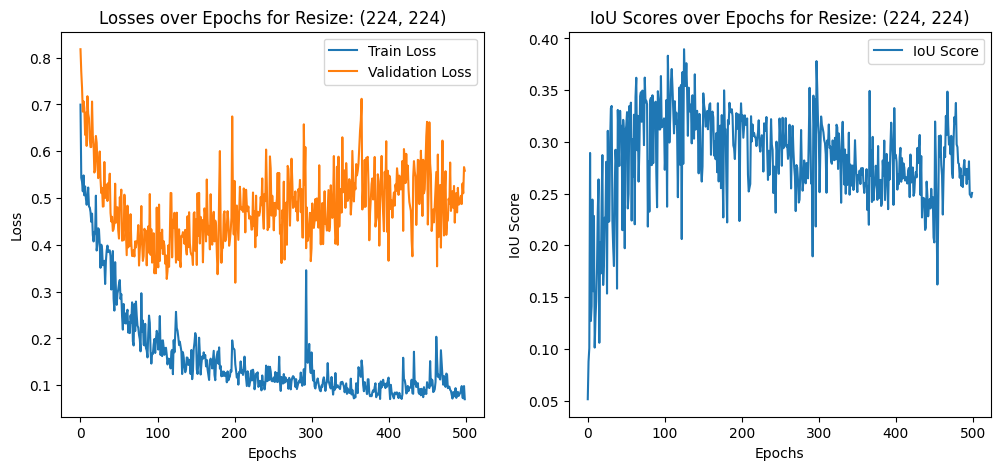

In [9]:
# Training Loop

# Input sizes to test
sizes = [(224, 224), ]
# Number of epochs for training
num_epochs = 500
# Get the base path of the project
base_path = os.getcwd()
# Path to images
base_path = os.path.join(base_path, 'BDS/png')
# Initialize the best loss as infinity
best_loss = float('inf')

for resize in sizes:
    print(f"Training model with image size: {resize}")
    # Create dataloaders for training and validation
    train_loader, val_loader = create_dataloaders(base_path, resize, batch_size=4)

    # Initialize lists to store losses and IoU scores
    train_losses = []
    val_losses = []
    iou_scores = []

    for epoch in range(num_epochs):
        model.train()  # Set the model to training mode
        running_loss = 0.0
        train_tqdm = tqdm(train_loader, desc=f'Epoch {epoch+1}/{num_epochs} Training', leave=True)
        for images, masks in train_tqdm:
            images, masks = images.to(device), masks.to(device)
            
            optimizer.zero_grad()  # Reset optimizer gradients
            outputs = model(images)  # Pass images through the model
            loss = criterion(outputs, masks)  # Calculate loss
            loss.backward()  # Backpropagate the error
            optimizer.step()  # Update weights
            
            running_loss += loss.item() * images.size(0)  # Accumulate scaled loss by batch size
            train_tqdm.set_postfix(loss=(running_loss / (train_tqdm.last_print_n + 1)))  # Update tqdm info
        
        epoch_loss = running_loss / len(train_loader.dataset)  # Calculate average loss for the epoch
        train_losses.append(epoch_loss)

        # Validation process to evaluate the model
        model.eval()  # Set the model to evaluation mode
        val_running_loss = 0.0
        ious = []
        val_tqdm = tqdm(val_loader, desc=f'Epoch {epoch+1}/{num_epochs} Validation', leave=True)
        with torch.no_grad():  # Disable gradient computation for validation
            for images, masks in val_tqdm:
                images, masks = images.to(device), masks.to(device)
                outputs = model(images)
                loss = criterion(outputs, masks)
                val_running_loss += loss.item() * images.size(0)
                
                iou = calculate_iou(outputs, masks)  # Calculate IoU
                ious.append(iou)
        
        val_epoch_loss = val_running_loss / len(val_loader.dataset)  # Average validation loss
        average_iou = np.mean(ious)  # Average IoU
        val_losses.append(val_epoch_loss)
        iou_scores.append(average_iou)
        
        # Print training and validation statistics
        print(f'Epoch {epoch+1}/{num_epochs}, Train Loss: {train_losses[-1]:.4f}, Val Loss: {val_losses[-1]:.4f}, Average IoU: {iou_scores[-1]:.4f}')

        # Save the model if the validation loss is the lowest so far
        if val_epoch_loss < best_loss:
            model_save_path = os.path.join('saved_models', f'model_BDS{resize[0]}x{resize[1]}.pth')
            os.makedirs('saved_models', exist_ok=True)
            torch.save(model.state_dict(), model_save_path)
            print(f"Model saved to {model_save_path}")
            best_loss = val_epoch_loss

    # Visualize graphs of losses and IoU
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(train_losses, label='Train Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.title(f'Losses over Epochs for Resize: {resize}')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(iou_scores, label='IoU Score')
    plt.title(f'IoU Scores over Epochs for Resize: {resize}')
    plt.xlabel('Epochs')
    plt.ylabel('IoU Score')
    plt.legend()
    plt.show()

    model.apply(weight_reset)  # Reset model weights for the next size configuration

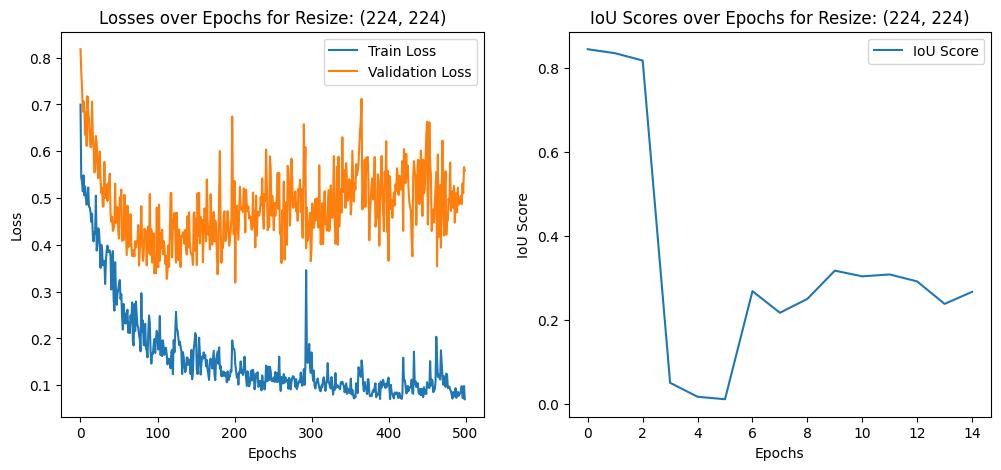

In [13]:
    # Visualize graphs of losses and IoU
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(train_losses, label='Train Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.title(f'Losses over Epochs for Resize: {resize}')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(iou_scores, label='IoU Score')
    plt.title(f'IoU Scores over Epochs for Resize: {resize}')
    plt.xlabel('Epochs')
    plt.ylabel('IoU Score')
    plt.legend()
    plt.show()

In [10]:
# Finally, we evaluate the model on the test set. 
# Besides the metrics, I think it's useful to see some examples where the original image, the true mask, and the predicted mask are displayed.

def create_test_dataloader(base_path, batch_size, resize):
    """
    Creates a DataLoader for the test dataset.

    Args:
        base_path (str): Base path where images and masks are stored.
        batch_size (int): Batch size.
        resize (tuple): Dimensions to which images and masks will be resized.

    Returns:
        DataLoader: DataLoader object configured for the test dataset.
    """
    # Transformations applied to the images
    transform_image = Compose([
        Resize(resize),
        ToTensor(),
        Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])

    # Transformations applied to the masks (only resizing and tensor conversion)
    transform_mask = Compose([
        Resize(resize),
        ToTensor()
    ])
    
    # Create the dataset using the specified directories
    test_dir = os.path.join(base_path, 'test')
    test_mask_dir = os.path.join(base_path, 'test_labels')
    test_dataset = SatelliteBuildingDataset(test_dir, test_mask_dir, transform_image, transform_mask)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    return test_loader

def plot_examples(data_loader, model, device, num_examples=5):
    """
    Displays examples of images, their true masks, and model predictions.

    Args:
        data_loader (DataLoader): DataLoader containing the test dataset.
        model (nn.Module): Neural network model to generate predictions.
        device (torch.device): Device where the model is running (CPU or GPU).
        num_examples (int): Number of examples to visualize.
    """
    fig, axs = plt.subplots(num_examples, 3, figsize=(15, num_examples * 5))
    model.eval()

    for idx, (images, masks) in enumerate(data_loader):
        if idx >= num_examples:
            break
        images, masks = images.to(device), masks.to(device)
        with torch.no_grad():
            outputs = model(images)
            preds = torch.sigmoid(outputs) > 0.5  # Convert logits to binary predictions

        # Visualize the original image, the true mask, and the predicted mask
        axs[idx, 0].imshow(images[0].cpu().permute(1, 2, 0))
        axs[idx, 0].set_title('Original Image')
        axs[idx, 0].axis('off')

        axs[idx, 1].imshow(masks[0].cpu().squeeze(), cmap='gray')
        axs[idx, 1].set_title('True Mask')
        axs[idx, 1].axis('off')

        axs[idx, 2].imshow(preds[0].cpu().squeeze(), cmap='gray')
        axs[idx, 2].set_title('Predicted Mask')
        axs[idx, 2].axis('off')

    plt.show()

Mean IoU for size (224, 224): 0.3349


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


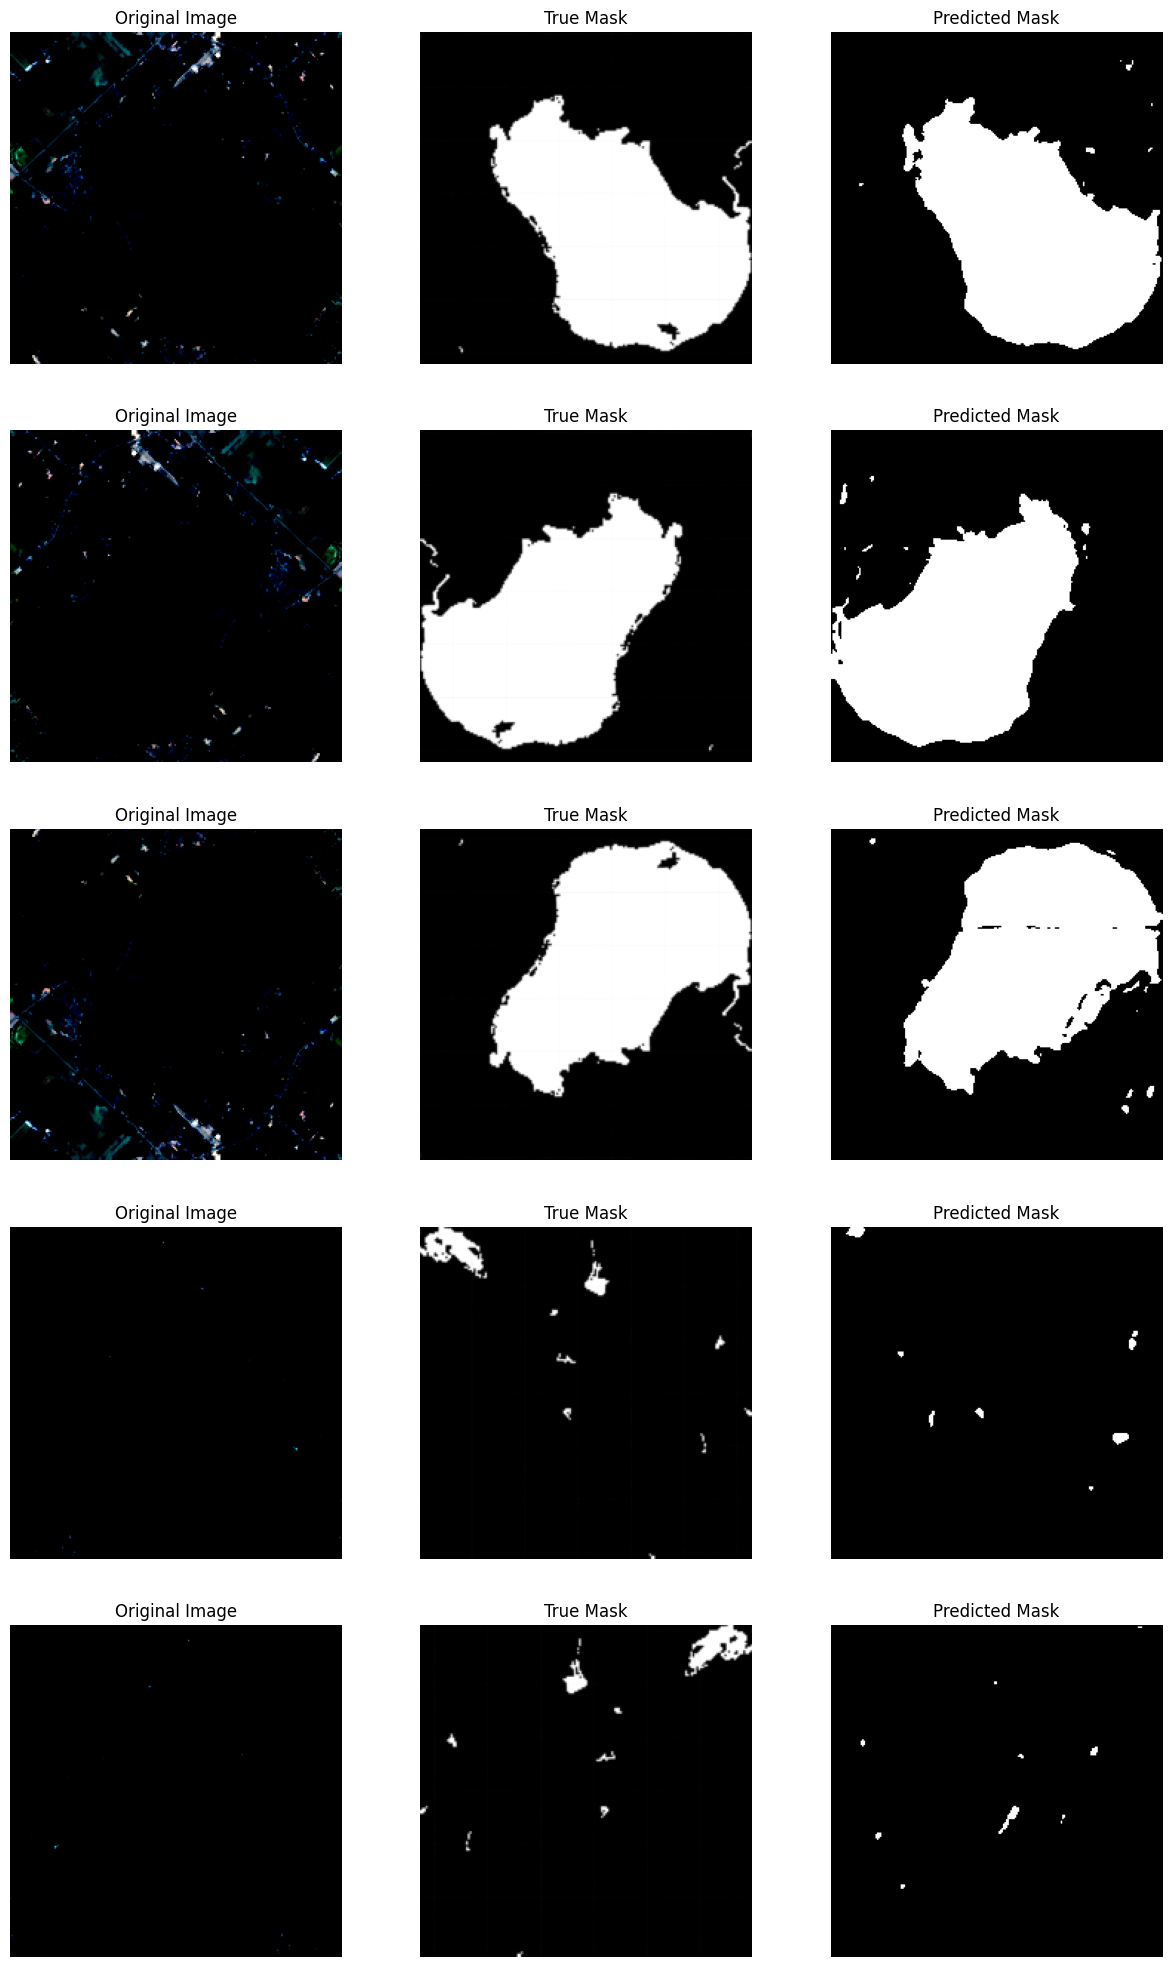

In [12]:
batch_size = 1

for resize in sizes:
    model_path = f'saved_models/model_BDS{resize[0]}x{resize[1]}.pth'
    test_loader = create_test_dataloader(base_path, batch_size, resize)
    
    model = UNet()  # Assume the model has been previously defined
    model.load_state_dict(torch.load(model_path))
    model.to(device)
    model.eval()
    
    iou_scores = []  # List to store IoU scores

    for images, true_masks in test_loader:
        images = images.to(device)
        true_masks = true_masks.to(device)

        with torch.no_grad():
            outputs = model(images)
            preds = torch.sigmoid(outputs) > 0.5  # Threshold to obtain binary masks

        preds_np = preds.cpu().numpy().astype(np.uint8)
        true_masks_np = true_masks.cpu().numpy().astype(np.uint8)

        # Calculate and store the IoU score for each image in the batch
        for pred, true_mask in zip(preds_np, true_masks_np):
            iou_score = jaccard_score(true_mask.flatten(), pred.flatten())
            iou_scores.append(iou_score)

    mean_iou = np.mean(iou_scores)  # Calculate the mean IoU for the current size
    print(f'Mean IoU for size {resize}: {mean_iou:.4f}')
    plot_examples(test_loader, model, device, num_examples=5)  # Visualize examples of predictions